In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import time
import pickle
%matplotlib inline

In [2]:
plt.rcParams['figure.figsize'] = [10, 5]

In [3]:
#header=None, sep=';'
yearly_df= pd.read_csv('Yearly Sunspots.csv', sep=',')

In [4]:
yearly_df.head()

,Date,Yearly Sunspot Number
0,1700/06,8.3
1,1701/06,18.3
2,1702/06,26.7
3,1703/06,38.3
4,1704/06,60.0


In [5]:
yearly_df.head()

,Date,Yearly Sunspot Number
0,1700/06,8.3
1,1701/06,18.3
2,1702/06,26.7
3,1703/06,38.3
4,1704/06,60.0


In [6]:
yearly_df['Date']=pd.to_datetime(yearly_df['Date'])

In [7]:
yearly_df=yearly_df.set_index(['Date'])

In [8]:
yearly_df.head()

,Yearly Sunspot Number
Date,
1700-06-01,8.3
1701-06-01,18.3
1702-06-01,26.7
1703-06-01,38.3
1704-06-01,60.0


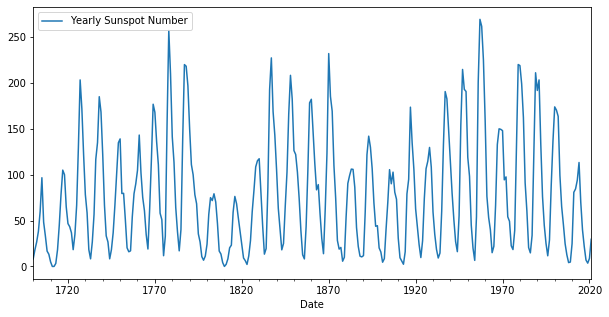

In [9]:
yearly_df.plot()

In [11]:
from statsmodels.tsa.stattools import adfuller

In [12]:
result= adfuller(yearly_df['Yearly Sunspot Number'].dropna())
print('p-value:', result[1])

p-value: 0.026067722399238793


In [13]:
dfoutput = pd.Series(result[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
for key,value in result[4].items():
    dfoutput['Critical Value (%s)'%key] = value
    
print(dfoutput)

Test Statistic                  -3.106612
p-value                          0.026068
#Lags Used                       8.000000
Number of Observations Used    313.000000
Critical Value (1%)             -3.451416
Critical Value (5%)             -2.870819
Critical Value (10%)            -2.571714
dtype: float64


#### p-value> 0.05 indicates the time series is non-stationary

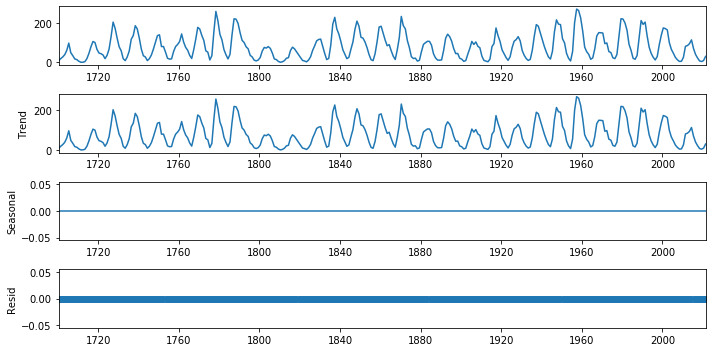

In [14]:
import statsmodels.api as sm

decomposition = sm.tsa.seasonal_decompose(yearly_df,model='additive')
fig = decomposition.plot()
plt.show()

## Differencing

In [15]:
from pmdarima.arima.utils import ndiffs

In [16]:
ndiffs(yearly_df['Yearly Sunspot Number'], test="adf")

0

### Time shift

In [17]:
yearly_df['Seasonal difference']=yearly_df['Yearly Sunspot Number']- yearly_df['Yearly Sunspot Number'].shift(11)

In [18]:
yearly_df.head()

,Yearly Sunspot Number,Seasonal difference
Date,,
1700-06-01,8.3,NaN
1701-06-01,18.3,NaN
1702-06-01,26.7,NaN
1703-06-01,38.3,NaN
1704-06-01,60.0,NaN


In [19]:
adfuller(yearly_df['Seasonal difference'].dropna())[1]

0.00023927052368609856

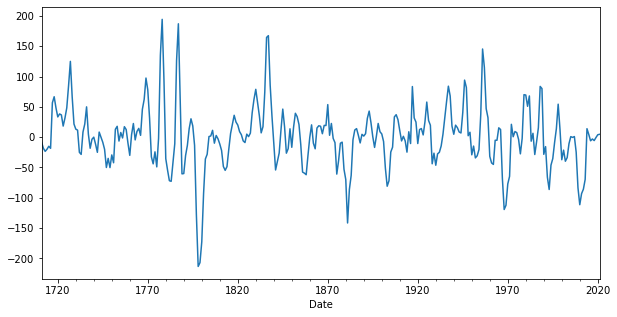

In [20]:
yearly_df['Seasonal difference'].dropna().plot()

####  After differencing once, the p-value<0.05

In [21]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

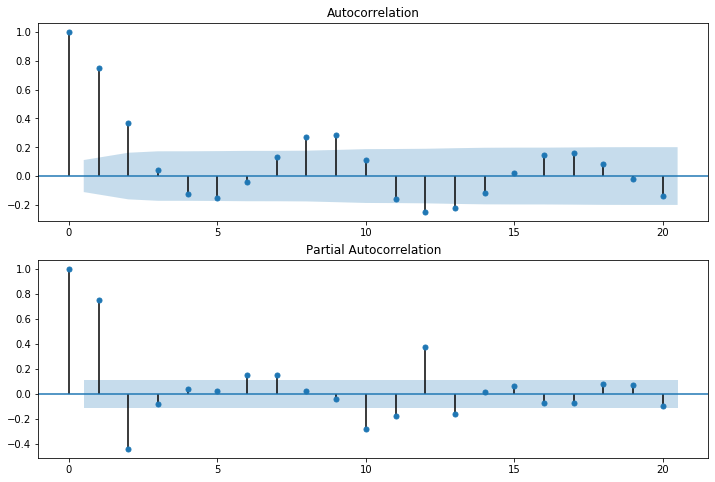

In [22]:
fig=plt.figure(figsize=(12,8))
ax1= fig.add_subplot(211)
fig=plot_acf(yearly_df['Seasonal difference'].dropna(),lags=20, ax=ax1)
ax2= fig.add_subplot(212)
fig=plot_pacf(yearly_df['Seasonal difference'].dropna(),lags=20, ax=ax2)

Till q=3, the autocorrelation is above 0.2 &
p=1 is significant

In [23]:
from scipy.signal import argrelextrema

In [24]:
lag_vals = np.arange(12*12)
autocorr_ser = np.array([yearly_df['Yearly Sunspot Number'].autocorr(lag=n) for n in lag_vals])
argrelextrema(autocorr_ser, np.less, order = 2)[0]
# we choose order = 2 because order = 1 gives two local maxima at lags = 125 and 128 months.

array([  5,  16,  27,  37,  48,  60,  71,  83,  94, 104, 115, 126, 137],
      dtype=int64)

In [25]:
ser = pd.Series(yearly_df['Yearly Sunspot Number'].values,index = yearly_df.index)

In [26]:
ser[argrelextrema(ser.values,np.less, order = 5)[0]]

Date
1723-06-01    18.3
1733-06-01     8.3
1744-06-01     8.3
1755-06-01    16.0
1766-06-01    19.0
1775-06-01    11.7
1784-06-01    17.0
1798-06-01     6.8
1810-06-01     0.0
1823-06-01     2.2
1833-06-01    13.4
1843-06-01    18.1
1856-06-01     8.2
1867-06-01    13.9
1878-06-01     5.7
1889-06-01    10.4
1901-06-01     4.6
1913-06-01     2.4
1923-06-01     9.7
1933-06-01     9.2
1944-06-01    16.1
1954-06-01     6.6
1964-06-01    15.0
1976-06-01    18.4
1986-06-01    14.8
1996-06-01    11.6
2008-06-01     4.2
2019-06-01     3.6
dtype: float64

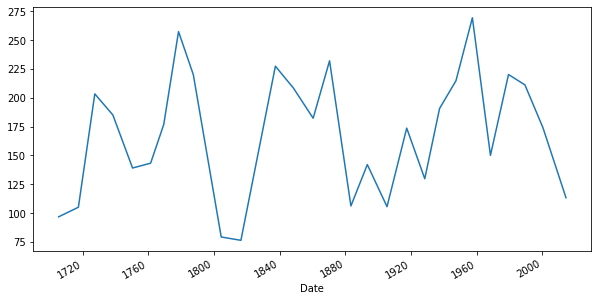

In [27]:
ser[argrelextrema(ser.values,np.greater, order = 7)[0]].plot()

## Model fitting

In [11]:
from statsmodels.tsa.arima_model import ARIMA 

In [12]:
dfp=yearly_df

In [13]:
df_train = dfp[:'1986-06-01']
df_test = dfp['1986-06-01':'2010-01-01']


In [ ]:
import statsmodels.api as sm 

In [31]:
 d = q  =range(0,2)
p=(0,1,2,6,7)

In [32]:
import itertools
SARIMA_AIC=pd.DataFrame(columns=['param', 'AIC'])
pdq=list(itertools.product(p,d,q))
seasonal_pdq = [(x[0], x[1], x[2], 11) for x in list(itertools.product(p,d,q))]

In [33]:
for param in pdq:
    for param_seasonal in seasonal_pdq:
        try:
            mod = sm.tsa.statespace.SARIMAX(df_train['Yearly Sunspot Number'],
                                            order= param,
                                           seasonal_order=param_seasonal,
                                           enforce_stationarity=False,
                                           enforce_invertibility=False)
            results = mod.fit()
            
            print('ARIMA{}x{}12 - AIC:{}'.format(param,param_seasonal,results.aic))
            SARIMA_AIC = SARIMA_AIC.append({'param':param,'seasonal param':param_seasonal ,
                                            'AIC': results.aic}, ignore_index=True)
        except:
            continue

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency AS-JUN will be used.
  % freq, ValueWarning)
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency AS-JUN will be used.
  % freq, ValueWarning)


ARIMA(0, 0, 0)x(0, 0, 0, 11)12 - AIC:3449.192631204258


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency AS-JUN will be used.
  % freq, ValueWarning)
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency AS-JUN will be used.
  % freq, ValueWarning)


ARIMA(0, 0, 0)x(0, 0, 1, 11)12 - AIC:3142.9740240518727
ARIMA(0, 0, 0)x(0, 1, 0, 11)12 - AIC:2956.708735237211


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency AS-JUN will be used.
  % freq, ValueWarning)
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency AS-JUN will be used.
  % freq, ValueWarning)
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency AS-JUN will be used.
  % freq, ValueWarning)
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency AS-JUN will be used.
  % freq, ValueWarning)


ARIMA(0, 0, 0)x(0, 1, 1, 11)12 - AIC:2834.244814728485
ARIMA(0, 0, 0)x(1, 0, 0, 11)12 - AIC:2956.95045298364


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency AS-JUN will be used.
  % freq, ValueWarning)
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency AS-JUN will be used.
  % freq, ValueWarning)
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency AS-JUN will be used.
  % freq, ValueWarning)
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency AS-JUN will be used.
  % freq, ValueWarning)


ARIMA(0, 0, 0)x(1, 0, 1, 11)12 - AIC:2944.4849380425744
ARIMA(0, 0, 0)x(1, 1, 0, 11)12 - AIC:2848.6073041677564


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency AS-JUN will be used.
  % freq, ValueWarning)
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency AS-JUN will be used.
  % freq, ValueWarning)
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency AS-JUN will be used.
  % freq, ValueWarning)
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency AS-JUN will be used.
  % freq, ValueWarning)


ARIMA(0, 0, 0)x(1, 1, 1, 11)12 - AIC:2809.8555315263843
ARIMA(0, 0, 0)x(2, 0, 0, 11)12 - AIC:2843.082884953395


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency AS-JUN will be used.
  % freq, ValueWarning)
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency AS-JUN will be used.
  % freq, ValueWarning)
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency AS-JUN will be used.
  % freq, ValueWarning)
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency AS-JUN will be used.
  % freq, ValueWarning)


ARIMA(0, 0, 0)x(2, 0, 1, 11)12 - AIC:2822.0946131964674
ARIMA(0, 0, 0)x(2, 1, 0, 11)12 - AIC:2722.815090868477


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency AS-JUN will be used.
  % freq, ValueWarning)
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency AS-JUN will be used.
  % freq, ValueWarning)
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency AS-JUN will be used.
  % freq, ValueWarning)
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency AS-JUN will be used.
  % freq, ValueWarning)


ARIMA(0, 0, 0)x(2, 1, 1, 11)12 - AIC:2700.990721423892


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency AS-JUN will be used.
  % freq, ValueWarning)
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency AS-JUN will be used.
  % freq, ValueWarning)


ARIMA(0, 0, 0)x(6, 0, 0, 11)12 - AIC:2385.4327183078694


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency AS-JUN will be used.
  % freq, ValueWarning)
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency AS-JUN will be used.
  % freq, ValueWarning)
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(0, 0, 0)x(6, 0, 1, 11)12 - AIC:2367.0549072571202


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency AS-JUN will be used.
  % freq, ValueWarning)
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency AS-JUN will be used.
  % freq, ValueWarning)


ARIMA(0, 0, 0)x(6, 1, 0, 11)12 - AIC:2266.0457835940088


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency AS-JUN will be used.
  % freq, ValueWarning)
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency AS-JUN will be used.
  % freq, ValueWarning)


ARIMA(0, 0, 0)x(6, 1, 1, 11)12 - AIC:2248.6018590400035


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency AS-JUN will be used.
  % freq, ValueWarning)
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency AS-JUN will be used.
  % freq, ValueWarning)
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(0, 0, 0)x(7, 0, 0, 11)12 - AIC:2267.6669979040585


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency AS-JUN will be used.
  % freq, ValueWarning)
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency AS-JUN will be used.
  % freq, ValueWarning)
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(0, 0, 0)x(7, 0, 1, 11)12 - AIC:2251.767498950804


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency AS-JUN will be used.
  % freq, ValueWarning)
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency AS-JUN will be used.
  % freq, ValueWarning)


ARIMA(0, 0, 0)x(7, 1, 0, 11)12 - AIC:2087.9027202068614


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency AS-JUN will be used.
  % freq, ValueWarning)
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency AS-JUN will be used.
  % freq, ValueWarning)


ARIMA(0, 0, 0)x(7, 1, 1, 11)12 - AIC:2089.6913747784974
ARIMA(0, 0, 1)x(0, 0, 0, 11)12 - AIC:3128.9216979386138


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency AS-JUN will be used.
  % freq, ValueWarning)
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency AS-JUN will be used.
  % freq, ValueWarning)
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency AS-JUN will be used.
  % freq, ValueWarning)
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency AS-JUN will be used.
  % freq, ValueWarning)


ARIMA(0, 0, 1)x(0, 0, 1, 11)12 - AIC:2885.4221929876494
ARIMA(0, 0, 1)x(0, 1, 0, 11)12 - AIC:2763.5375699573196


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency AS-JUN will be used.
  % freq, ValueWarning)
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency AS-JUN will be used.
  % freq, ValueWarning)
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency AS-JUN will be used.
  % freq, ValueWarning)
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency AS-JUN will be used.
  % freq, ValueWarning)


ARIMA(0, 0, 1)x(0, 1, 1, 11)12 - AIC:2631.493029924932
ARIMA(0, 0, 1)x(1, 0, 0, 11)12 - AIC:2765.673367326719


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency AS-JUN will be used.
  % freq, ValueWarning)
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency AS-JUN will be used.
  % freq, ValueWarning)
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency AS-JUN will be used.
  % freq, ValueWarning)
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency AS-JUN will be used.
  % freq, ValueWarning)


ARIMA(0, 0, 1)x(1, 0, 1, 11)12 - AIC:2736.1408409676537


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency AS-JUN will be used.
  % freq, ValueWarning)
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency AS-JUN will be used.
  % freq, ValueWarning)


ARIMA(0, 0, 1)x(1, 1, 0, 11)12 - AIC:2662.496099649157


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency AS-JUN will be used.
  % freq, ValueWarning)
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency AS-JUN will be used.
  % freq, ValueWarning)


ARIMA(0, 0, 1)x(1, 1, 1, 11)12 - AIC:2608.5759650714554


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency AS-JUN will be used.
  % freq, ValueWarning)
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency AS-JUN will be used.
  % freq, ValueWarning)


ARIMA(0, 0, 1)x(2, 0, 0, 11)12 - AIC:2654.4916111095545


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency AS-JUN will be used.
  % freq, ValueWarning)
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency AS-JUN will be used.
  % freq, ValueWarning)


ARIMA(0, 0, 1)x(2, 0, 1, 11)12 - AIC:2630.1742559692143


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency AS-JUN will be used.
  % freq, ValueWarning)
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency AS-JUN will be used.
  % freq, ValueWarning)


ARIMA(0, 0, 1)x(2, 1, 0, 11)12 - AIC:2544.8250532890956


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency AS-JUN will be used.
  % freq, ValueWarning)
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency AS-JUN will be used.
  % freq, ValueWarning)


ARIMA(0, 0, 1)x(2, 1, 1, 11)12 - AIC:2517.9098635309583


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency AS-JUN will be used.
  % freq, ValueWarning)
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency AS-JUN will be used.
  % freq, ValueWarning)


ARIMA(0, 0, 1)x(6, 0, 0, 11)12 - AIC:2229.49689045572


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency AS-JUN will be used.
  % freq, ValueWarning)
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency AS-JUN will be used.
  % freq, ValueWarning)


ARIMA(0, 0, 1)x(6, 0, 1, 11)12 - AIC:2213.3044644945694


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency AS-JUN will be used.
  % freq, ValueWarning)
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency AS-JUN will be used.
  % freq, ValueWarning)


ARIMA(0, 0, 1)x(6, 1, 0, 11)12 - AIC:2116.352650676343


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency AS-JUN will be used.
  % freq, ValueWarning)
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency AS-JUN will be used.
  % freq, ValueWarning)


ARIMA(0, 0, 1)x(6, 1, 1, 11)12 - AIC:2101.7137528273033


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency AS-JUN will be used.
  % freq, ValueWarning)
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency AS-JUN will be used.
  % freq, ValueWarning)


ARIMA(0, 0, 1)x(7, 0, 0, 11)12 - AIC:2117.783140853764


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency AS-JUN will be used.
  % freq, ValueWarning)
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency AS-JUN will be used.
  % freq, ValueWarning)
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(0, 0, 1)x(7, 0, 1, 11)12 - AIC:2104.0194061491893


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency AS-JUN will be used.
  % freq, ValueWarning)
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency AS-JUN will be used.
  % freq, ValueWarning)


ARIMA(0, 0, 1)x(7, 1, 0, 11)12 - AIC:1964.64466990962


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency AS-JUN will be used.
  % freq, ValueWarning)
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency AS-JUN will be used.
  % freq, ValueWarning)


ARIMA(0, 0, 1)x(7, 1, 1, 11)12 - AIC:1958.0243696284806
ARIMA(0, 1, 0)x(0, 0, 0, 11)12 - AIC:2874.4057242125273
ARIMA(0, 1, 0)x(0, 0, 1, 11)12 - AIC:2716.4234637857685


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency AS-JUN will be used.
  % freq, ValueWarning)
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency AS-JUN will be used.
  % freq, ValueWarning)
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency AS-JUN will be used.
  % freq, ValueWarning)
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency AS-JUN will be used.
  % freq, ValueWarning)
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency AS-JUN will be used.
  % freq, Valu

ARIMA(0, 1, 0)x(0, 1, 0, 11)12 - AIC:2757.741845120619


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency AS-JUN will be used.
  % freq, ValueWarning)
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency AS-JUN will be used.
  % freq, ValueWarning)


ARIMA(0, 1, 0)x(0, 1, 1, 11)12 - AIC:2595.8383010903203
ARIMA(0, 1, 0)x(1, 0, 0, 11)12 - AIC:2699.027211496003
ARIMA(0, 1, 0)x(1, 0, 1, 11)12 - AIC:2684.2924414029176


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency AS-JUN will be used.
  % freq, ValueWarning)
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency AS-JUN will be used.
  % freq, ValueWarning)
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency AS-JUN will be used.
  % freq, ValueWarning)
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency AS-JUN will be used.
  % freq, ValueWarning)
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency AS-JUN will be used.
  % freq, Valu

ARIMA(0, 1, 0)x(1, 1, 0, 11)12 - AIC:2627.375679520849


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency AS-JUN will be used.
  % freq, ValueWarning)
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency AS-JUN will be used.
  % freq, ValueWarning)


ARIMA(0, 1, 0)x(1, 1, 1, 11)12 - AIC:2590.005566021662
ARIMA(0, 1, 0)x(2, 0, 0, 11)12 - AIC:2593.0446607033296


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency AS-JUN will be used.
  % freq, ValueWarning)
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency AS-JUN will be used.
  % freq, ValueWarning)
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency AS-JUN will be used.
  % freq, ValueWarning)
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency AS-JUN will be used.
  % freq, ValueWarning)


ARIMA(0, 1, 0)x(2, 0, 1, 11)12 - AIC:2593.7271860758865
ARIMA(0, 1, 0)x(2, 1, 0, 11)12 - AIC:2508.5594376894305


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency AS-JUN will be used.
  % freq, ValueWarning)
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency AS-JUN will be used.
  % freq, ValueWarning)
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency AS-JUN will be used.
  % freq, ValueWarning)
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency AS-JUN will be used.
  % freq, ValueWarning)


ARIMA(0, 1, 0)x(2, 1, 1, 11)12 - AIC:2491.048182697508


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency AS-JUN will be used.
  % freq, ValueWarning)
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency AS-JUN will be used.
  % freq, ValueWarning)


ARIMA(0, 1, 0)x(6, 0, 0, 11)12 - AIC:2183.896818419823


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency AS-JUN will be used.
  % freq, ValueWarning)
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency AS-JUN will be used.
  % freq, ValueWarning)


ARIMA(0, 1, 0)x(6, 0, 1, 11)12 - AIC:2179.6027530388146


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency AS-JUN will be used.
  % freq, ValueWarning)
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency AS-JUN will be used.
  % freq, ValueWarning)


ARIMA(0, 1, 0)x(6, 1, 0, 11)12 - AIC:2067.712832120871


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency AS-JUN will be used.
  % freq, ValueWarning)
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency AS-JUN will be used.
  % freq, ValueWarning)


ARIMA(0, 1, 0)x(6, 1, 1, 11)12 - AIC:2060.1528919424704


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency AS-JUN will be used.
  % freq, ValueWarning)
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency AS-JUN will be used.
  % freq, ValueWarning)


ARIMA(0, 1, 0)x(7, 0, 0, 11)12 - AIC:2060.028231925213


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency AS-JUN will be used.
  % freq, ValueWarning)
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency AS-JUN will be used.
  % freq, ValueWarning)


ARIMA(0, 1, 0)x(7, 0, 1, 11)12 - AIC:2055.3464974839917


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency AS-JUN will be used.
  % freq, ValueWarning)
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency AS-JUN will be used.
  % freq, ValueWarning)


ARIMA(0, 1, 0)x(7, 1, 0, 11)12 - AIC:1913.6380791469405


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency AS-JUN will be used.
  % freq, ValueWarning)
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency AS-JUN will be used.
  % freq, ValueWarning)


ARIMA(0, 1, 0)x(7, 1, 1, 11)12 - AIC:1915.0357384188692
ARIMA(0, 1, 1)x(0, 0, 0, 11)12 - AIC:2779.2097408178156


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency AS-JUN will be used.
  % freq, ValueWarning)
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency AS-JUN will be used.
  % freq, ValueWarning)
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency AS-JUN will be used.
  % freq, ValueWarning)
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency AS-JUN will be used.
  % freq, ValueWarning)


ARIMA(0, 1, 1)x(0, 0, 1, 11)12 - AIC:2650.3688275349477
ARIMA(0, 1, 1)x(0, 1, 0, 11)12 - AIC:2727.8424805707627


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency AS-JUN will be used.
  % freq, ValueWarning)
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency AS-JUN will be used.
  % freq, ValueWarning)
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency AS-JUN will be used.
  % freq, ValueWarning)
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency AS-JUN will be used.
  % freq, ValueWarning)


ARIMA(0, 1, 1)x(0, 1, 1, 11)12 - AIC:2543.672488814711
ARIMA(0, 1, 1)x(1, 0, 0, 11)12 - AIC:2657.108133183813


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency AS-JUN will be used.
  % freq, ValueWarning)
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency AS-JUN will be used.
  % freq, ValueWarning)
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency AS-JUN will be used.
  % freq, ValueWarning)
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency AS-JUN will be used.
  % freq, ValueWarning)


ARIMA(0, 1, 1)x(1, 0, 1, 11)12 - AIC:2634.779484540468
ARIMA(0, 1, 1)x(1, 1, 0, 11)12 - AIC:2598.2353759705347

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency AS-JUN will be used.
  % freq, ValueWarning)
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency AS-JUN will be used.
  % freq, ValueWarning)


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency AS-JUN will be used.
  % freq, ValueWarning)
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency AS-JUN will be used.
  % freq, ValueWarning)


ARIMA(0, 1, 1)x(1, 1, 1, 11)12 - AIC:2541.3856432208227


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency AS-JUN will be used.
  % freq, ValueWarning)
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency AS-JUN will be used.
  % freq, ValueWarning)


ARIMA(0, 1, 1)x(2, 0, 0, 11)12 - AIC:2554.2620949176717


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency AS-JUN will be used.
  % freq, ValueWarning)
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency AS-JUN will be used.
  % freq, ValueWarning)


ARIMA(0, 1, 1)x(2, 0, 1, 11)12 - AIC:2554.7261390556273


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency AS-JUN will be used.
  % freq, ValueWarning)
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency AS-JUN will be used.
  % freq, ValueWarning)


ARIMA(0, 1, 1)x(2, 1, 0, 11)12 - AIC:2478.1947794231287


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency AS-JUN will be used.
  % freq, ValueWarning)
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency AS-JUN will be used.
  % freq, ValueWarning)


ARIMA(0, 1, 1)x(2, 1, 1, 11)12 - AIC:2454.0454873726803


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency AS-JUN will be used.
  % freq, ValueWarning)
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency AS-JUN will be used.
  % freq, ValueWarning)


ARIMA(0, 1, 1)x(6, 0, 0, 11)12 - AIC:2151.8054710635042


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency AS-JUN will be used.
  % freq, ValueWarning)
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency AS-JUN will be used.
  % freq, ValueWarning)


ARIMA(0, 1, 1)x(6, 0, 1, 11)12 - AIC:2153.8036304659036


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency AS-JUN will be used.
  % freq, ValueWarning)
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency AS-JUN will be used.
  % freq, ValueWarning)


ARIMA(0, 1, 1)x(6, 1, 0, 11)12 - AIC:2046.973540924187


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency AS-JUN will be used.
  % freq, ValueWarning)
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency AS-JUN will be used.
  % freq, ValueWarning)


ARIMA(0, 1, 1)x(6, 1, 1, 11)12 - AIC:2037.7042147584339


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency AS-JUN will be used.
  % freq, ValueWarning)
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency AS-JUN will be used.
  % freq, ValueWarning)


ARIMA(0, 1, 1)x(7, 0, 0, 11)12 - AIC:2034.145899841953


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency AS-JUN will be used.
  % freq, ValueWarning)
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency AS-JUN will be used.
  % freq, ValueWarning)


ARIMA(0, 1, 1)x(7, 0, 1, 11)12 - AIC:2028.1675952139024


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency AS-JUN will be used.
  % freq, ValueWarning)
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency AS-JUN will be used.
  % freq, ValueWarning)


ARIMA(0, 1, 1)x(7, 1, 0, 11)12 - AIC:1900.3317292614747


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency AS-JUN will be used.
  % freq, ValueWarning)
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency AS-JUN will be used.
  % freq, ValueWarning)


ARIMA(0, 1, 1)x(7, 1, 1, 11)12 - AIC:1902.3140578650314
ARIMA(1, 0, 0)x(0, 0, 0, 11)12 - AIC:2875.492384186775


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency AS-JUN will be used.
  % freq, ValueWarning)
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency AS-JUN will be used.
  % freq, ValueWarning)
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency AS-JUN will be used.
  % freq, ValueWarning)
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency AS-JUN will be used.
  % freq, ValueWarning)


ARIMA(1, 0, 0)x(0, 0, 1, 11)12 - AIC:2714.1316722894153
ARIMA(1, 0, 0)x(0, 1, 0, 11)12 - AIC:2732.0370176107367


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency AS-JUN will be used.
  % freq, ValueWarning)
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency AS-JUN will be used.
  % freq, ValueWarning)
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency AS-JUN will be used.
  % freq, ValueWarning)
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency AS-JUN will be used.
  % freq, ValueWarning)


ARIMA(1, 0, 0)x(0, 1, 1, 11)12 - AIC:2579.411959042685
ARIMA(1, 0, 0)x(1, 0, 0, 11)12 - AIC:2680.825588506295


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency AS-JUN will be used.
  % freq, ValueWarning)
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency AS-JUN will be used.
  % freq, ValueWarning)
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency AS-JUN will be used.
  % freq, ValueWarning)
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency AS-JUN will be used.
  % freq, ValueWarning)


ARIMA(1, 0, 0)x(1, 0, 1, 11)12 - AIC:2672.129467802235
ARIMA(1, 0, 0)x(1, 1, 0, 11)12 - AIC:2598.9053695876332


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency AS-JUN will be used.
  % freq, ValueWarning)
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency AS-JUN will be used.
  % freq, ValueWarning)
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency AS-JUN will be used.
  % freq, ValueWarning)
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency AS-JUN will be used.
  % freq, ValueWarning)


ARIMA(1, 0, 0)x(1, 1, 1, 11)12 - AIC:2570.4376317197957


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency AS-JUN will be used.
  % freq, ValueWarning)
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency AS-JUN will be used.
  % freq, ValueWarning)


ARIMA(1, 0, 0)x(2, 0, 0, 11)12 - AIC:2573.428404068805


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency AS-JUN will be used.
  % freq, ValueWarning)
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency AS-JUN will be used.
  % freq, ValueWarning)


ARIMA(1, 0, 0)x(2, 0, 1, 11)12 - AIC:2573.2182207978603


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency AS-JUN will be used.
  % freq, ValueWarning)
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency AS-JUN will be used.
  % freq, ValueWarning)


ARIMA(1, 0, 0)x(2, 1, 0, 11)12 - AIC:2482.4567426804697


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency AS-JUN will be used.
  % freq, ValueWarning)
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency AS-JUN will be used.
  % freq, ValueWarning)


ARIMA(1, 0, 0)x(2, 1, 1, 11)12 - AIC:2463.5642980137213


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency AS-JUN will be used.
  % freq, ValueWarning)
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency AS-JUN will be used.
  % freq, ValueWarning)


ARIMA(1, 0, 0)x(6, 0, 0, 11)12 - AIC:2167.3435131714896


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency AS-JUN will be used.
  % freq, ValueWarning)
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency AS-JUN will be used.
  % freq, ValueWarning)


ARIMA(1, 0, 0)x(6, 0, 1, 11)12 - AIC:2157.0291185893757


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency AS-JUN will be used.
  % freq, ValueWarning)
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency AS-JUN will be used.
  % freq, ValueWarning)


ARIMA(1, 0, 0)x(6, 1, 0, 11)12 - AIC:2044.6653281567555


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency AS-JUN will be used.
  % freq, ValueWarning)
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency AS-JUN will be used.
  % freq, ValueWarning)


ARIMA(1, 0, 0)x(6, 1, 1, 11)12 - AIC:2042.0461355156401


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency AS-JUN will be used.
  % freq, ValueWarning)
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency AS-JUN will be used.
  % freq, ValueWarning)


ARIMA(1, 0, 0)x(7, 0, 0, 11)12 - AIC:2040.987793419204


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency AS-JUN will be used.
  % freq, ValueWarning)
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency AS-JUN will be used.
  % freq, ValueWarning)


ARIMA(1, 0, 0)x(7, 0, 1, 11)12 - AIC:2041.684847314325


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency AS-JUN will be used.
  % freq, ValueWarning)
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency AS-JUN will be used.
  % freq, ValueWarning)


ARIMA(1, 0, 0)x(7, 1, 0, 11)12 - AIC:1889.6582560228762


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency AS-JUN will be used.
  % freq, ValueWarning)
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency AS-JUN will be used.
  % freq, ValueWarning)


ARIMA(1, 0, 0)x(7, 1, 1, 11)12 - AIC:1891.2910580339612
ARIMA(1, 0, 1)x(0, 0, 0, 11)12 - AIC:2774.5167352930284


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency AS-JUN will be used.
  % freq, ValueWarning)
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency AS-JUN will be used.
  % freq, ValueWarning)
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency AS-JUN will be used.
  % freq, ValueWarning)
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency AS-JUN will be used.
  % freq, ValueWarning)


ARIMA(1, 0, 1)x(0, 0, 1, 11)12 - AIC:2642.1205198631533
ARIMA(1, 0, 1)x(0, 1, 0, 11)12 - AIC:2684.8884195297696


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency AS-JUN will be used.
  % freq, ValueWarning)
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency AS-JUN will be used.
  % freq, ValueWarning)
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency AS-JUN will be used.
  % freq, ValueWarning)
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency AS-JUN will be used.
  % freq, ValueWarning)


ARIMA(1, 0, 1)x(0, 1, 1, 11)12 - AIC:2515.624819705328
ARIMA(1, 0, 1)x(1, 0, 0, 11)12 - AIC:2633.908907048836


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency AS-JUN will be used.
  % freq, ValueWarning)
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency AS-JUN will be used.
  % freq, ValueWarning)
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency AS-JUN will be used.
  % freq, ValueWarning)
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency AS-JUN will be used.
  % freq, ValueWarning)


ARIMA(1, 0, 1)x(1, 0, 1, 11)12 - AIC:2614.210646121248


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency AS-JUN will be used.
  % freq, ValueWarning)
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency AS-JUN will be used.
  % freq, ValueWarning)


ARIMA(1, 0, 1)x(1, 1, 0, 11)12 - AIC:2555.97602312909


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency AS-JUN will be used.
  % freq, ValueWarning)
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency AS-JUN will be used.
  % freq, ValueWarning)


ARIMA(1, 0, 1)x(1, 1, 1, 11)12 - AIC:2508.7634768689295


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency AS-JUN will be used.
  % freq, ValueWarning)
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency AS-JUN will be used.
  % freq, ValueWarning)


ARIMA(1, 0, 1)x(2, 0, 0, 11)12 - AIC:2527.8058098673755


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency AS-JUN will be used.
  % freq, ValueWarning)
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency AS-JUN will be used.
  % freq, ValueWarning)


ARIMA(1, 0, 1)x(2, 0, 1, 11)12 - AIC:2521.0093195460286


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency AS-JUN will be used.
  % freq, ValueWarning)
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency AS-JUN will be used.
  % freq, ValueWarning)


ARIMA(1, 0, 1)x(2, 1, 0, 11)12 - AIC:2439.594794591004


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency AS-JUN will be used.
  % freq, ValueWarning)
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency AS-JUN will be used.
  % freq, ValueWarning)


ARIMA(1, 0, 1)x(2, 1, 1, 11)12 - AIC:2413.703877392868


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency AS-JUN will be used.
  % freq, ValueWarning)
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency AS-JUN will be used.
  % freq, ValueWarning)


ARIMA(1, 0, 1)x(6, 0, 0, 11)12 - AIC:2128.2552929936655


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency AS-JUN will be used.
  % freq, ValueWarning)
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency AS-JUN will be used.
  % freq, ValueWarning)
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(1, 0, 1)x(6, 0, 1, 11)12 - AIC:2122.453286063364


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency AS-JUN will be used.
  % freq, ValueWarning)
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency AS-JUN will be used.
  % freq, ValueWarning)


ARIMA(1, 0, 1)x(6, 1, 0, 11)12 - AIC:2012.4996339718887


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency AS-JUN will be used.
  % freq, ValueWarning)
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency AS-JUN will be used.
  % freq, ValueWarning)


ARIMA(1, 0, 1)x(6, 1, 1, 11)12 - AIC:2001.9697269680348


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency AS-JUN will be used.
  % freq, ValueWarning)
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency AS-JUN will be used.
  % freq, ValueWarning)


ARIMA(1, 0, 1)x(7, 0, 0, 11)12 - AIC:2013.6818976824925


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency AS-JUN will be used.
  % freq, ValueWarning)
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency AS-JUN will be used.
  % freq, ValueWarning)


ARIMA(1, 0, 1)x(7, 0, 1, 11)12 - AIC:2010.9670287642393


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency AS-JUN will be used.
  % freq, ValueWarning)
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency AS-JUN will be used.
  % freq, ValueWarning)


ARIMA(1, 0, 1)x(7, 1, 0, 11)12 - AIC:1870.16362525534


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency AS-JUN will be used.
  % freq, ValueWarning)
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency AS-JUN will be used.
  % freq, ValueWarning)


ARIMA(1, 0, 1)x(7, 1, 1, 11)12 - AIC:1871.9886747267578
ARIMA(1, 1, 0)x(0, 0, 0, 11)12 - AIC:2778.585889092272
ARIMA(1, 1, 0)x(0, 0, 1, 11)12 - AIC:2656.340396178727

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency AS-JUN will be used.
  % freq, ValueWarning)
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency AS-JUN will be used.
  % freq, ValueWarning)
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency AS-JUN will be used.
  % freq, ValueWarning)
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency AS-JUN will be used.
  % freq, ValueWarning)
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency AS-JUN will be used.
  % freq, Valu


ARIMA(1, 1, 0)x(0, 1, 0, 11)12 - AIC:2740.0404723092342


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency AS-JUN will be used.
  % freq, ValueWarning)
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency AS-JUN will be used.
  % freq, ValueWarning)
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency AS-JUN will be used.
  % freq, ValueWarning)


ARIMA(1, 1, 0)x(0, 1, 1, 11)12 - AIC:2550.124939563175
ARIMA(1, 1, 0)x(1, 0, 0, 11)12 - AIC:2647.7823062624325


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency AS-JUN will be used.
  % freq, ValueWarning)
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency AS-JUN will be used.
  % freq, ValueWarning)
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency AS-JUN will be used.
  % freq, ValueWarning)
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency AS-JUN will be used.
  % freq, ValueWarning)


ARIMA(1, 1, 0)x(1, 0, 1, 11)12 - AIC:2642.849154417763
ARIMA(1, 1, 0)x(1, 1, 0, 11)12 - AIC:2589.754142892499


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency AS-JUN will be used.
  % freq, ValueWarning)
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency AS-JUN will be used.
  % freq, ValueWarning)
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency AS-JUN will be used.
  % freq, ValueWarning)
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency AS-JUN will be used.
  % freq, ValueWarning)


ARIMA(1, 1, 0)x(1, 1, 1, 11)12 - AIC:2550.3992619299124


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency AS-JUN will be used.
  % freq, ValueWarning)
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency AS-JUN will be used.
  % freq, ValueWarning)


ARIMA(1, 1, 0)x(2, 0, 0, 11)12 - AIC:2544.1513789777923


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency AS-JUN will be used.
  % freq, ValueWarning)
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency AS-JUN will be used.
  % freq, ValueWarning)


ARIMA(1, 1, 0)x(2, 0, 1, 11)12 - AIC:2544.9439143818463


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency AS-JUN will be used.
  % freq, ValueWarning)
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency AS-JUN will be used.
  % freq, ValueWarning)


ARIMA(1, 1, 0)x(2, 1, 0, 11)12 - AIC:2469.090194201472


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency AS-JUN will be used.
  % freq, ValueWarning)
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency AS-JUN will be used.
  % freq, ValueWarning)


ARIMA(1, 1, 0)x(2, 1, 1, 11)12 - AIC:2443.9659551750146


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency AS-JUN will be used.
  % freq, ValueWarning)
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency AS-JUN will be used.
  % freq, ValueWarning)


ARIMA(1, 1, 0)x(6, 0, 0, 11)12 - AIC:2140.112827660867


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency AS-JUN will be used.
  % freq, ValueWarning)
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency AS-JUN will be used.
  % freq, ValueWarning)


ARIMA(1, 1, 0)x(6, 0, 1, 11)12 - AIC:2128.4997641746622


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency AS-JUN will be used.
  % freq, ValueWarning)
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency AS-JUN will be used.
  % freq, ValueWarning)


ARIMA(1, 1, 0)x(6, 1, 0, 11)12 - AIC:2031.5032226679696


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency AS-JUN will be used.
  % freq, ValueWarning)
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency AS-JUN will be used.
  % freq, ValueWarning)


ARIMA(1, 1, 0)x(6, 1, 1, 11)12 - AIC:2028.8475854396934


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency AS-JUN will be used.
  % freq, ValueWarning)
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency AS-JUN will be used.
  % freq, ValueWarning)


ARIMA(1, 1, 0)x(7, 0, 0, 11)12 - AIC:2019.9227430121662


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency AS-JUN will be used.
  % freq, ValueWarning)
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency AS-JUN will be used.
  % freq, ValueWarning)


ARIMA(1, 1, 0)x(7, 0, 1, 11)12 - AIC:2008.568391659921


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency AS-JUN will be used.
  % freq, ValueWarning)
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency AS-JUN will be used.
  % freq, ValueWarning)


ARIMA(1, 1, 0)x(7, 1, 0, 11)12 - AIC:1884.9333532051478


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency AS-JUN will be used.
  % freq, ValueWarning)
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency AS-JUN will be used.
  % freq, ValueWarning)


ARIMA(1, 1, 0)x(7, 1, 1, 11)12 - AIC:1886.9239261688463
ARIMA(1, 1, 1)x(0, 0, 0, 11)12 - AIC:2763.078037905483


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency AS-JUN will be used.
  % freq, ValueWarning)
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency AS-JUN will be used.
  % freq, ValueWarning)
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency AS-JUN will be used.
  % freq, ValueWarning)
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency AS-JUN will be used.
  % freq, ValueWarning)


ARIMA(1, 1, 1)x(0, 0, 1, 11)12 - AIC:2643.450347696681
ARIMA(1, 1, 1)x(0, 1, 0, 11)12 - AIC:2729.6630737165397


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency AS-JUN will be used.
  % freq, ValueWarning)
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency AS-JUN will be used.
  % freq, ValueWarning)
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency AS-JUN will be used.
  % freq, ValueWarning)
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency AS-JUN will be used.
  % freq, ValueWarning)


ARIMA(1, 1, 1)x(0, 1, 1, 11)12 - AIC:2538.908240715007
ARIMA(1, 1, 1)x(1, 0, 0, 11)12 - AIC:2644.9548086992395


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency AS-JUN will be used.
  % freq, ValueWarning)
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency AS-JUN will be used.
  % freq, ValueWarning)
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency AS-JUN will be used.
  % freq, ValueWarning)
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency AS-JUN will be used.
  % freq, ValueWarning)


ARIMA(1, 1, 1)x(1, 0, 1, 11)12 - AIC:2631.893692387199


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency AS-JUN will be used.
  % freq, ValueWarning)
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency AS-JUN will be used.
  % freq, ValueWarning)


ARIMA(1, 1, 1)x(1, 1, 0, 11)12 - AIC:2588.8826317445173


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency AS-JUN will be used.
  % freq, ValueWarning)
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency AS-JUN will be used.
  % freq, ValueWarning)


ARIMA(1, 1, 1)x(1, 1, 1, 11)12 - AIC:2539.143724937183


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency AS-JUN will be used.
  % freq, ValueWarning)
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency AS-JUN will be used.
  % freq, ValueWarning)


ARIMA(1, 1, 1)x(2, 0, 0, 11)12 - AIC:2542.182181367255


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency AS-JUN will be used.
  % freq, ValueWarning)
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency AS-JUN will be used.
  % freq, ValueWarning)


ARIMA(1, 1, 1)x(2, 0, 1, 11)12 - AIC:2543.022455543092


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency AS-JUN will be used.
  % freq, ValueWarning)
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency AS-JUN will be used.
  % freq, ValueWarning)


ARIMA(1, 1, 1)x(2, 1, 0, 11)12 - AIC:2468.365260532914


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency AS-JUN will be used.
  % freq, ValueWarning)
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency AS-JUN will be used.
  % freq, ValueWarning)


ARIMA(1, 1, 1)x(2, 1, 1, 11)12 - AIC:2442.357350831574


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency AS-JUN will be used.
  % freq, ValueWarning)
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency AS-JUN will be used.
  % freq, ValueWarning)


ARIMA(1, 1, 1)x(6, 0, 0, 11)12 - AIC:2138.144006259989


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency AS-JUN will be used.
  % freq, ValueWarning)
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency AS-JUN will be used.
  % freq, ValueWarning)


ARIMA(1, 1, 1)x(6, 0, 1, 11)12 - AIC:2128.033990285694


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency AS-JUN will be used.
  % freq, ValueWarning)
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency AS-JUN will be used.
  % freq, ValueWarning)


ARIMA(1, 1, 1)x(6, 1, 0, 11)12 - AIC:2031.9476240682416


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency AS-JUN will be used.
  % freq, ValueWarning)
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency AS-JUN will be used.
  % freq, ValueWarning)


ARIMA(1, 1, 1)x(6, 1, 1, 11)12 - AIC:2027.9762151921668


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency AS-JUN will be used.
  % freq, ValueWarning)
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency AS-JUN will be used.
  % freq, ValueWarning)


ARIMA(1, 1, 1)x(7, 0, 0, 11)12 - AIC:2018.7724618200543


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency AS-JUN will be used.
  % freq, ValueWarning)
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency AS-JUN will be used.
  % freq, ValueWarning)


ARIMA(1, 1, 1)x(7, 0, 1, 11)12 - AIC:2009.5744153429127


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency AS-JUN will be used.
  % freq, ValueWarning)
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency AS-JUN will be used.
  % freq, ValueWarning)


ARIMA(1, 1, 1)x(7, 1, 0, 11)12 - AIC:1886.8258561792672


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency AS-JUN will be used.
  % freq, ValueWarning)
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency AS-JUN will be used.
  % freq, ValueWarning)


ARIMA(1, 1, 1)x(7, 1, 1, 11)12 - AIC:1888.809783820749
ARIMA(2, 0, 0)x(0, 0, 0, 11)12 - AIC:2744.23612301499


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency AS-JUN will be used.
  % freq, ValueWarning)
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency AS-JUN will be used.
  % freq, ValueWarning)
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency AS-JUN will be used.
  % freq, ValueWarning)
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency AS-JUN will be used.
  % freq, ValueWarning)


ARIMA(2, 0, 0)x(0, 0, 1, 11)12 - AIC:2631.384290511793
ARIMA(2, 0, 0)x(0, 1, 0, 11)12 - AIC:2664.5565265451078


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency AS-JUN will be used.
  % freq, ValueWarning)
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency AS-JUN will be used.
  % freq, ValueWarning)
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency AS-JUN will be used.
  % freq, ValueWarning)
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency AS-JUN will be used.
  % freq, ValueWarning)


ARIMA(2, 0, 0)x(0, 1, 1, 11)12 - AIC:2481.3603789738636
ARIMA(2, 0, 0)x(1, 0, 0, 11)12 - AIC:2610.002942834687

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency AS-JUN will be used.
  % freq, ValueWarning)
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency AS-JUN will be used.
  % freq, ValueWarning)


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency AS-JUN will be used.
  % freq, ValueWarning)
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency AS-JUN will be used.
  % freq, ValueWarning)


ARIMA(2, 0, 0)x(1, 0, 1, 11)12 - AIC:2577.335446348915


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency AS-JUN will be used.
  % freq, ValueWarning)
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency AS-JUN will be used.
  % freq, ValueWarning)


ARIMA(2, 0, 0)x(1, 1, 0, 11)12 - AIC:2520.8273171511237


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency AS-JUN will be used.
  % freq, ValueWarning)
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency AS-JUN will be used.
  % freq, ValueWarning)


ARIMA(2, 0, 0)x(1, 1, 1, 11)12 - AIC:2471.0510226762435


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency AS-JUN will be used.
  % freq, ValueWarning)
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency AS-JUN will be used.
  % freq, ValueWarning)


ARIMA(2, 0, 0)x(2, 0, 0, 11)12 - AIC:2499.418827622212


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency AS-JUN will be used.
  % freq, ValueWarning)
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency AS-JUN will be used.
  % freq, ValueWarning)


ARIMA(2, 0, 0)x(2, 0, 1, 11)12 - AIC:2474.3842515086353


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency AS-JUN will be used.
  % freq, ValueWarning)
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency AS-JUN will be used.
  % freq, ValueWarning)


ARIMA(2, 0, 0)x(2, 1, 0, 11)12 - AIC:2404.0637099951246


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency AS-JUN will be used.
  % freq, ValueWarning)
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency AS-JUN will be used.
  % freq, ValueWarning)


ARIMA(2, 0, 0)x(2, 1, 1, 11)12 - AIC:2366.8524151701213


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency AS-JUN will be used.
  % freq, ValueWarning)
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency AS-JUN will be used.
  % freq, ValueWarning)


ARIMA(2, 0, 0)x(6, 0, 0, 11)12 - AIC:2089.2906899203563


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency AS-JUN will be used.
  % freq, ValueWarning)
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency AS-JUN will be used.
  % freq, ValueWarning)


ARIMA(2, 0, 0)x(6, 0, 1, 11)12 - AIC:2083.14543785602


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency AS-JUN will be used.
  % freq, ValueWarning)
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency AS-JUN will be used.
  % freq, ValueWarning)


ARIMA(2, 0, 0)x(6, 1, 0, 11)12 - AIC:1962.5002641063402


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency AS-JUN will be used.
  % freq, ValueWarning)
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency AS-JUN will be used.
  % freq, ValueWarning)


ARIMA(2, 0, 0)x(6, 1, 1, 11)12 - AIC:1959.2833595716056


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency AS-JUN will be used.
  % freq, ValueWarning)
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency AS-JUN will be used.
  % freq, ValueWarning)


ARIMA(2, 0, 0)x(7, 0, 0, 11)12 - AIC:1962.1708008514615


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency AS-JUN will be used.
  % freq, ValueWarning)
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency AS-JUN will be used.
  % freq, ValueWarning)


ARIMA(2, 0, 0)x(7, 0, 1, 11)12 - AIC:1962.3240765985424


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency AS-JUN will be used.
  % freq, ValueWarning)
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency AS-JUN will be used.
  % freq, ValueWarning)


ARIMA(2, 0, 0)x(7, 1, 0, 11)12 - AIC:1840.5061267579526


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency AS-JUN will be used.
  % freq, ValueWarning)
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency AS-JUN will be used.
  % freq, ValueWarning)


ARIMA(2, 0, 0)x(7, 1, 1, 11)12 - AIC:1842.4366287297457
ARIMA(2, 0, 1)x(0, 0, 0, 11)12 - AIC:2742.75683571416


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency AS-JUN will be used.
  % freq, ValueWarning)
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency AS-JUN will be used.
  % freq, ValueWarning)
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency AS-JUN will be used.
  % freq, ValueWarning)
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency AS-JUN will be used.
  % freq, ValueWarning)


ARIMA(2, 0, 1)x(0, 0, 1, 11)12 - AIC:2623.0076638679266
ARIMA(2, 0, 1)x(0, 1, 0, 11)12 - AIC:2665.445293365273


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency AS-JUN will be used.
  % freq, ValueWarning)
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency AS-JUN will be used.
  % freq, ValueWarning)
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency AS-JUN will be used.
  % freq, ValueWarning)
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency AS-JUN will be used.
  % freq, ValueWarning)


ARIMA(2, 0, 1)x(0, 1, 1, 11)12 - AIC:2472.352883802606


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency AS-JUN will be used.
  % freq, ValueWarning)
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency AS-JUN will be used.
  % freq, ValueWarning)


ARIMA(2, 0, 1)x(1, 0, 0, 11)12 - AIC:2611.451141823021


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency AS-JUN will be used.
  % freq, ValueWarning)
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency AS-JUN will be used.
  % freq, ValueWarning)


ARIMA(2, 0, 1)x(1, 0, 1, 11)12 - AIC:2576.773476225932


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency AS-JUN will be used.
  % freq, ValueWarning)
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency AS-JUN will be used.
  % freq, ValueWarning)


ARIMA(2, 0, 1)x(1, 1, 0, 11)12 - AIC:2521.649136737402


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency AS-JUN will be used.
  % freq, ValueWarning)
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency AS-JUN will be used.
  % freq, ValueWarning)


ARIMA(2, 0, 1)x(1, 1, 1, 11)12 - AIC:2470.6299886562283


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency AS-JUN will be used.
  % freq, ValueWarning)
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency AS-JUN will be used.
  % freq, ValueWarning)


ARIMA(2, 0, 1)x(2, 0, 0, 11)12 - AIC:2501.417749374551


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency AS-JUN will be used.
  % freq, ValueWarning)
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency AS-JUN will be used.
  % freq, ValueWarning)


ARIMA(2, 0, 1)x(2, 0, 1, 11)12 - AIC:2473.6965329065847


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency AS-JUN will be used.
  % freq, ValueWarning)
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency AS-JUN will be used.
  % freq, ValueWarning)


ARIMA(2, 0, 1)x(2, 1, 0, 11)12 - AIC:2404.5907333599225


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency AS-JUN will be used.
  % freq, ValueWarning)
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency AS-JUN will be used.
  % freq, ValueWarning)


ARIMA(2, 0, 1)x(2, 1, 1, 11)12 - AIC:2365.9446497581853


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency AS-JUN will be used.
  % freq, ValueWarning)
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency AS-JUN will be used.
  % freq, ValueWarning)


ARIMA(2, 0, 1)x(6, 0, 0, 11)12 - AIC:2090.330143783841


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency AS-JUN will be used.
  % freq, ValueWarning)
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency AS-JUN will be used.
  % freq, ValueWarning)


ARIMA(2, 0, 1)x(6, 0, 1, 11)12 - AIC:2083.7224556077936


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency AS-JUN will be used.
  % freq, ValueWarning)
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency AS-JUN will be used.
  % freq, ValueWarning)


ARIMA(2, 0, 1)x(6, 1, 0, 11)12 - AIC:1961.6268210454155


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency AS-JUN will be used.
  % freq, ValueWarning)
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency AS-JUN will be used.
  % freq, ValueWarning)


ARIMA(2, 0, 1)x(6, 1, 1, 11)12 - AIC:1957.4677119330527


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency AS-JUN will be used.
  % freq, ValueWarning)
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency AS-JUN will be used.
  % freq, ValueWarning)


ARIMA(2, 0, 1)x(7, 0, 0, 11)12 - AIC:1963.5877913808952


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency AS-JUN will be used.
  % freq, ValueWarning)
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency AS-JUN will be used.
  % freq, ValueWarning)


ARIMA(2, 0, 1)x(7, 0, 1, 11)12 - AIC:1963.1424377618782


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency AS-JUN will be used.
  % freq, ValueWarning)
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency AS-JUN will be used.
  % freq, ValueWarning)


ARIMA(2, 0, 1)x(7, 1, 0, 11)12 - AIC:1838.484006720122


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency AS-JUN will be used.
  % freq, ValueWarning)
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency AS-JUN will be used.
  % freq, ValueWarning)


ARIMA(2, 0, 1)x(7, 1, 1, 11)12 - AIC:1840.4113897668626
ARIMA(2, 1, 0)x(0, 0, 0, 11)12 - AIC:2753.3116063174766


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency AS-JUN will be used.
  % freq, ValueWarning)
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency AS-JUN will be used.
  % freq, ValueWarning)
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency AS-JUN will be used.
  % freq, ValueWarning)
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency AS-JUN will be used.
  % freq, ValueWarning)


ARIMA(2, 1, 0)x(0, 0, 1, 11)12 - AIC:2644.9583835894973
ARIMA(2, 1, 0)x(0, 1, 0, 11)12 - AIC:2722.953781894248


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency AS-JUN will be used.
  % freq, ValueWarning)
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency AS-JUN will be used.
  % freq, ValueWarning)
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency AS-JUN will be used.
  % freq, ValueWarning)
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency AS-JUN will be used.
  % freq, ValueWarning)


ARIMA(2, 1, 0)x(0, 1, 1, 11)12 - AIC:2543.2524149158453
ARIMA(2, 1, 0)x(1, 0, 0, 11)12 - AIC:2630.068489915945


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency AS-JUN will be used.
  % freq, ValueWarning)
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency AS-JUN will be used.
  % freq, ValueWarning)
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency AS-JUN will be used.
  % freq, ValueWarning)
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency AS-JUN will be used.
  % freq, ValueWarning)


ARIMA(2, 1, 0)x(1, 0, 1, 11)12 - AIC:2626.1873841780953


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency AS-JUN will be used.
  % freq, ValueWarning)
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency AS-JUN will be used.
  % freq, ValueWarning)


ARIMA(2, 1, 0)x(1, 1, 0, 11)12 - AIC:2574.5582895320176


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency AS-JUN will be used.
  % freq, ValueWarning)
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency AS-JUN will be used.
  % freq, ValueWarning)


ARIMA(2, 1, 0)x(1, 1, 1, 11)12 - AIC:2533.674534094051


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency AS-JUN will be used.
  % freq, ValueWarning)
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency AS-JUN will be used.
  % freq, ValueWarning)


ARIMA(2, 1, 0)x(2, 0, 0, 11)12 - AIC:2527.436352665166


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency AS-JUN will be used.
  % freq, ValueWarning)
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency AS-JUN will be used.
  % freq, ValueWarning)


ARIMA(2, 1, 0)x(2, 0, 1, 11)12 - AIC:2528.6420598893656


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency AS-JUN will be used.
  % freq, ValueWarning)
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency AS-JUN will be used.
  % freq, ValueWarning)


ARIMA(2, 1, 0)x(2, 1, 0, 11)12 - AIC:2455.2999005242846


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency AS-JUN will be used.
  % freq, ValueWarning)
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency AS-JUN will be used.
  % freq, ValueWarning)


ARIMA(2, 1, 0)x(2, 1, 1, 11)12 - AIC:2428.8792249349317


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency AS-JUN will be used.
  % freq, ValueWarning)
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency AS-JUN will be used.
  % freq, ValueWarning)


ARIMA(2, 1, 0)x(6, 0, 0, 11)12 - AIC:2123.3586014139537


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency AS-JUN will be used.
  % freq, ValueWarning)
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency AS-JUN will be used.
  % freq, ValueWarning)


ARIMA(2, 1, 0)x(6, 0, 1, 11)12 - AIC:2114.563452321332


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency AS-JUN will be used.
  % freq, ValueWarning)
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency AS-JUN will be used.
  % freq, ValueWarning)


ARIMA(2, 1, 0)x(6, 1, 0, 11)12 - AIC:2007.3387428903166


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency AS-JUN will be used.
  % freq, ValueWarning)
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency AS-JUN will be used.
  % freq, ValueWarning)


ARIMA(2, 1, 0)x(6, 1, 1, 11)12 - AIC:2008.042256228964


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency AS-JUN will be used.
  % freq, ValueWarning)
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency AS-JUN will be used.
  % freq, ValueWarning)


ARIMA(2, 1, 0)x(7, 0, 0, 11)12 - AIC:1995.9650879615795


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency AS-JUN will be used.
  % freq, ValueWarning)
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency AS-JUN will be used.
  % freq, ValueWarning)


ARIMA(2, 1, 0)x(7, 0, 1, 11)12 - AIC:1990.668809564386


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency AS-JUN will be used.
  % freq, ValueWarning)
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency AS-JUN will be used.
  % freq, ValueWarning)


ARIMA(2, 1, 0)x(7, 1, 0, 11)12 - AIC:1877.5820656610972


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency AS-JUN will be used.
  % freq, ValueWarning)
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency AS-JUN will be used.
  % freq, ValueWarning)


ARIMA(2, 1, 0)x(7, 1, 1, 11)12 - AIC:1879.554240478033
ARIMA(2, 1, 1)x(0, 0, 0, 11)12 - AIC:2662.0788898045485


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency AS-JUN will be used.
  % freq, ValueWarning)
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency AS-JUN will be used.
  % freq, ValueWarning)
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency AS-JUN will be used.
  % freq, ValueWarning)
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency AS-JUN will be used.
  % freq, ValueWarning)


ARIMA(2, 1, 1)x(0, 0, 1, 11)12 - AIC:2553.0741162906925


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency AS-JUN will be used.
  % freq, ValueWarning)
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency AS-JUN will be used.
  % freq, ValueWarning)


ARIMA(2, 1, 1)x(0, 1, 0, 11)12 - AIC:2661.8311829737895


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency AS-JUN will be used.
  % freq, ValueWarning)
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency AS-JUN will be used.
  % freq, ValueWarning)


ARIMA(2, 1, 1)x(0, 1, 1, 11)12 - AIC:2466.6502048860007


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency AS-JUN will be used.
  % freq, ValueWarning)
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency AS-JUN will be used.
  % freq, ValueWarning)


ARIMA(2, 1, 1)x(1, 0, 0, 11)12 - AIC:2550.8385554210827


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency AS-JUN will be used.
  % freq, ValueWarning)
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency AS-JUN will be used.
  % freq, ValueWarning)


ARIMA(2, 1, 1)x(1, 0, 1, 11)12 - AIC:2552.0513529193336


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency AS-JUN will be used.
  % freq, ValueWarning)
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency AS-JUN will be used.
  % freq, ValueWarning)


ARIMA(2, 1, 1)x(1, 1, 0, 11)12 - AIC:2517.844028043904


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency AS-JUN will be used.
  % freq, ValueWarning)
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency AS-JUN will be used.
  % freq, ValueWarning)


ARIMA(2, 1, 1)x(1, 1, 1, 11)12 - AIC:2467.53251816149


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency AS-JUN will be used.
  % freq, ValueWarning)
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency AS-JUN will be used.
  % freq, ValueWarning)


ARIMA(2, 1, 1)x(2, 0, 0, 11)12 - AIC:2455.5578320127734


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency AS-JUN will be used.
  % freq, ValueWarning)
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency AS-JUN will be used.
  % freq, ValueWarning)


ARIMA(2, 1, 1)x(2, 0, 1, 11)12 - AIC:2456.68135846218


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency AS-JUN will be used.
  % freq, ValueWarning)
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency AS-JUN will be used.
  % freq, ValueWarning)


ARIMA(2, 1, 1)x(2, 1, 0, 11)12 - AIC:2401.3259907290067


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency AS-JUN will be used.
  % freq, ValueWarning)
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency AS-JUN will be used.
  % freq, ValueWarning)


ARIMA(2, 1, 1)x(2, 1, 1, 11)12 - AIC:2366.6424116633634


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency AS-JUN will be used.
  % freq, ValueWarning)
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency AS-JUN will be used.
  % freq, ValueWarning)


ARIMA(2, 1, 1)x(6, 0, 0, 11)12 - AIC:2063.4331110139137


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency AS-JUN will be used.
  % freq, ValueWarning)
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency AS-JUN will be used.
  % freq, ValueWarning)


ARIMA(2, 1, 1)x(6, 0, 1, 11)12 - AIC:2056.0236518468237


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency AS-JUN will be used.
  % freq, ValueWarning)
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency AS-JUN will be used.
  % freq, ValueWarning)


ARIMA(2, 1, 1)x(6, 1, 0, 11)12 - AIC:1957.9434437108791


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency AS-JUN will be used.
  % freq, ValueWarning)
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency AS-JUN will be used.
  % freq, ValueWarning)
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(2, 1, 1)x(6, 1, 1, 11)12 - AIC:1955.4619441719951


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency AS-JUN will be used.
  % freq, ValueWarning)
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency AS-JUN will be used.
  % freq, ValueWarning)


ARIMA(2, 1, 1)x(7, 0, 0, 11)12 - AIC:1941.4326249442838


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency AS-JUN will be used.
  % freq, ValueWarning)
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency AS-JUN will be used.
  % freq, ValueWarning)


ARIMA(2, 1, 1)x(7, 0, 1, 11)12 - AIC:1936.9448823414855


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency AS-JUN will be used.
  % freq, ValueWarning)
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency AS-JUN will be used.
  % freq, ValueWarning)


ARIMA(2, 1, 1)x(7, 1, 0, 11)12 - AIC:1839.069975946373


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency AS-JUN will be used.
  % freq, ValueWarning)
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency AS-JUN will be used.
  % freq, ValueWarning)


ARIMA(2, 1, 1)x(7, 1, 1, 11)12 - AIC:1838.6289120854733
ARIMA(6, 0, 0)x(0, 0, 0, 11)12 - AIC:2660.5955271810826


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency AS-JUN will be used.
  % freq, ValueWarning)
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency AS-JUN will be used.
  % freq, ValueWarning)
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency AS-JUN will be used.
  % freq, ValueWarning)
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency AS-JUN will be used.
  % freq, ValueWarning)


ARIMA(6, 0, 0)x(0, 0, 1, 11)12 - AIC:2595.9039981030874
ARIMA(6, 0, 0)x(0, 1, 0, 11)12 - AIC:2628.233970528741


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency AS-JUN will be used.
  % freq, ValueWarning)
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency AS-JUN will be used.
  % freq, ValueWarning)
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency AS-JUN will be used.
  % freq, ValueWarning)
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency AS-JUN will be used.
  % freq, ValueWarning)


ARIMA(6, 0, 0)x(0, 1, 1, 11)12 - AIC:2478.9074851844944


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency AS-JUN will be used.
  % freq, ValueWarning)
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency AS-JUN will be used.
  % freq, ValueWarning)
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency AS-JUN will be used.
  % freq, ValueWarning)
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency AS-JUN will be used.
  % freq,

ARIMA(6, 0, 0)x(1, 0, 0, 11)12 - AIC:2549.0687327631917
ARIMA(6, 0, 0)x(1, 0, 1, 11)12 - AIC:2542.0701992587947


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency AS-JUN will be used.
  % freq, ValueWarning)
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency AS-JUN will be used.
  % freq, ValueWarning)


ARIMA(6, 0, 0)x(1, 1, 0, 11)12 - AIC:2476.4007343913854


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency AS-JUN will be used.
  % freq, ValueWarning)
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency AS-JUN will be used.
  % freq, ValueWarning)


ARIMA(6, 0, 0)x(1, 1, 1, 11)12 - AIC:2429.734634221616


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency AS-JUN will be used.
  % freq, ValueWarning)
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency AS-JUN will be used.
  % freq, ValueWarning)


ARIMA(6, 0, 0)x(2, 0, 0, 11)12 - AIC:2440.6970082979174


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency AS-JUN will be used.
  % freq, ValueWarning)
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency AS-JUN will be used.
  % freq, ValueWarning)
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency AS-JUN will be used.
  % freq, ValueWarning)
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency AS-JUN will be used.
  % freq,

ARIMA(6, 0, 0)x(2, 0, 1, 11)12 - AIC:2441.6287853922104
ARIMA(6, 0, 0)x(2, 1, 0, 11)12 - AIC:2364.568466132646


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency AS-JUN will be used.
  % freq, ValueWarning)
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency AS-JUN will be used.
  % freq, ValueWarning)


ARIMA(6, 0, 0)x(2, 1, 1, 11)12 - AIC:2332.2928048371405


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency AS-JUN will be used.
  % freq, ValueWarning)
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency AS-JUN will be used.
  % freq, ValueWarning)


ARIMA(6, 0, 0)x(6, 0, 0, 11)12 - AIC:2046.3148906514928


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency AS-JUN will be used.
  % freq, ValueWarning)
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency AS-JUN will be used.
  % freq, ValueWarning)
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(6, 0, 0)x(6, 0, 1, 11)12 - AIC:2046.733833654006


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency AS-JUN will be used.
  % freq, ValueWarning)
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency AS-JUN will be used.
  % freq, ValueWarning)


ARIMA(6, 0, 0)x(6, 1, 0, 11)12 - AIC:1917.0955968401954


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency AS-JUN will be used.
  % freq, ValueWarning)
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency AS-JUN will be used.
  % freq, ValueWarning)
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(6, 0, 0)x(6, 1, 1, 11)12 - AIC:1911.616406204962


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency AS-JUN will be used.
  % freq, ValueWarning)
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency AS-JUN will be used.
  % freq, ValueWarning)


ARIMA(6, 0, 0)x(7, 0, 0, 11)12 - AIC:1915.4820872833832


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency AS-JUN will be used.
  % freq, ValueWarning)
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency AS-JUN will be used.
  % freq, ValueWarning)


ARIMA(6, 0, 0)x(7, 0, 1, 11)12 - AIC:1914.109509565778


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency AS-JUN will be used.
  % freq, ValueWarning)
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency AS-JUN will be used.
  % freq, ValueWarning)


ARIMA(6, 0, 0)x(7, 1, 0, 11)12 - AIC:1802.7602374943194


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency AS-JUN will be used.
  % freq, ValueWarning)
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency AS-JUN will be used.
  % freq, ValueWarning)


ARIMA(6, 0, 0)x(7, 1, 1, 11)12 - AIC:1804.7602230018856


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency AS-JUN will be used.
  % freq, ValueWarning)
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency AS-JUN will be used.
  % freq, ValueWarning)
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency AS-JUN will be used.
  % freq, ValueWarning)
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency AS-JUN will be used.
  % freq,

ARIMA(6, 0, 1)x(0, 0, 0, 11)12 - AIC:2612.7083896706063


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency AS-JUN will be used.
  % freq, ValueWarning)
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency AS-JUN will be used.
  % freq, ValueWarning)


ARIMA(6, 0, 1)x(0, 0, 1, 11)12 - AIC:2550.7602093122473
ARIMA(6, 0, 1)x(0, 1, 0, 11)12 - AIC:2626.711911334467


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency AS-JUN will be used.
  % freq, ValueWarning)
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency AS-JUN will be used.
  % freq, ValueWarning)
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(6, 0, 1)x(0, 1, 1, 11)12 - AIC:2453.55591423669


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency AS-JUN will be used.
  % freq, ValueWarning)
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency AS-JUN will be used.
  % freq, ValueWarning)
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency AS-JUN will be used.
  % freq, ValueWarning)
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency AS-JUN will be used.
  % freq,

ARIMA(6, 0, 1)x(1, 0, 0, 11)12 - AIC:2511.580747175035


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency AS-JUN will be used.
  % freq, ValueWarning)
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency AS-JUN will be used.
  % freq, ValueWarning)


ARIMA(6, 0, 1)x(1, 0, 1, 11)12 - AIC:2514.259285629797


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency AS-JUN will be used.
  % freq, ValueWarning)
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency AS-JUN will be used.
  % freq, ValueWarning)


ARIMA(6, 0, 1)x(1, 1, 0, 11)12 - AIC:2470.057211258544


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency AS-JUN will be used.
  % freq, ValueWarning)
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency AS-JUN will be used.
  % freq, ValueWarning)


ARIMA(6, 0, 1)x(1, 1, 1, 11)12 - AIC:2416.956267430602


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency AS-JUN will be used.
  % freq, ValueWarning)
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency AS-JUN will be used.
  % freq, ValueWarning)


ARIMA(6, 0, 1)x(2, 0, 0, 11)12 - AIC:2416.202498671486


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency AS-JUN will be used.
  % freq, ValueWarning)
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency AS-JUN will be used.
  % freq, ValueWarning)


ARIMA(6, 0, 1)x(2, 0, 1, 11)12 - AIC:2420.2976304674253


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency AS-JUN will be used.
  % freq, ValueWarning)
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency AS-JUN will be used.
  % freq, ValueWarning)


ARIMA(6, 0, 1)x(2, 1, 0, 11)12 - AIC:2357.741156602305


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(6, 0, 1)x(2, 1, 1, 11)12 - AIC:2330.21827950833


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency AS-JUN will be used.
  % freq, ValueWarning)
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency AS-JUN will be used.
  % freq, ValueWarning)
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(6, 0, 1)x(6, 0, 0, 11)12 - AIC:2024.5089375284267


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency AS-JUN will be used.
  % freq, ValueWarning)
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency AS-JUN will be used.
  % freq, ValueWarning)
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(6, 0, 1)x(6, 0, 1, 11)12 - AIC:2027.3869575962208


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency AS-JUN will be used.
  % freq, ValueWarning)
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency AS-JUN will be used.
  % freq, ValueWarning)
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(6, 0, 1)x(6, 1, 0, 11)12 - AIC:1911.680182127564


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency AS-JUN will be used.
  % freq, ValueWarning)
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency AS-JUN will be used.
  % freq, ValueWarning)
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(6, 0, 1)x(6, 1, 1, 11)12 - AIC:1909.1024780404728


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency AS-JUN will be used.
  % freq, ValueWarning)
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency AS-JUN will be used.
  % freq, ValueWarning)
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(6, 0, 1)x(7, 0, 0, 11)12 - AIC:1902.5621065489477


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency AS-JUN will be used.
  % freq, ValueWarning)
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency AS-JUN will be used.
  % freq, ValueWarning)
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(6, 0, 1)x(7, 0, 1, 11)12 - AIC:1902.3178605905573


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency AS-JUN will be used.
  % freq, ValueWarning)
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency AS-JUN will be used.
  % freq, ValueWarning)
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(6, 0, 1)x(7, 1, 0, 11)12 - AIC:1802.620322532523


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency AS-JUN will be used.
  % freq, ValueWarning)
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency AS-JUN will be used.
  % freq, ValueWarning)
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(6, 0, 1)x(7, 1, 1, 11)12 - AIC:1804.7452431754086
ARIMA(6, 1, 0)x(0, 0, 0, 11)12 - AIC:2625.2257637349057


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency AS-JUN will be used.
  % freq, ValueWarning)
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency AS-JUN will be used.
  % freq, ValueWarning)
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency AS-JUN will be used.
  % freq, ValueWarning)
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency AS-JUN will be used.
  % freq, ValueWarning)


ARIMA(6, 1, 0)x(0, 0, 1, 11)12 - AIC:2569.2758634829297
ARIMA(6, 1, 0)x(0, 1, 0, 11)12 - AIC:2626.312158617591


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency AS-JUN will be used.
  % freq, ValueWarning)
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency AS-JUN will be used.
  % freq, ValueWarning)
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency AS-JUN will be used.
  % freq, ValueWarning)
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency AS-JUN will be used.
  % freq, ValueWarning)


ARIMA(6, 1, 0)x(0, 1, 1, 11)12 - AIC:2477.110846434239


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency AS-JUN will be used.
  % freq, ValueWarning)
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency AS-JUN will be used.
  % freq, ValueWarning)


ARIMA(6, 1, 0)x(1, 0, 0, 11)12 - AIC:2522.6914370536556


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency AS-JUN will be used.
  % freq, ValueWarning)
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency AS-JUN will be used.
  % freq, ValueWarning)


ARIMA(6, 1, 0)x(1, 0, 1, 11)12 - AIC:2518.983750126753


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency AS-JUN will be used.
  % freq, ValueWarning)
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency AS-JUN will be used.
  % freq, ValueWarning)


ARIMA(6, 1, 0)x(1, 1, 0, 11)12 - AIC:2471.863508787435


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency AS-JUN will be used.
  % freq, ValueWarning)
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency AS-JUN will be used.
  % freq, ValueWarning)


ARIMA(6, 1, 0)x(1, 1, 1, 11)12 - AIC:2429.208896087558


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency AS-JUN will be used.
  % freq, ValueWarning)
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency AS-JUN will be used.
  % freq, ValueWarning)


ARIMA(6, 1, 0)x(2, 0, 0, 11)12 - AIC:2416.4652234761443


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency AS-JUN will be used.
  % freq, ValueWarning)
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency AS-JUN will be used.
  % freq, ValueWarning)


ARIMA(6, 1, 0)x(2, 0, 1, 11)12 - AIC:2418.31033800956


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency AS-JUN will be used.
  % freq, ValueWarning)
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency AS-JUN will be used.
  % freq, ValueWarning)


ARIMA(6, 1, 0)x(2, 1, 0, 11)12 - AIC:2363.465201589933


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency AS-JUN will be used.
  % freq, ValueWarning)
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency AS-JUN will be used.
  % freq, ValueWarning)


ARIMA(6, 1, 0)x(2, 1, 1, 11)12 - AIC:2333.666137936012


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency AS-JUN will be used.
  % freq, ValueWarning)
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency AS-JUN will be used.
  % freq, ValueWarning)


ARIMA(6, 1, 0)x(6, 0, 0, 11)12 - AIC:2028.495653521215


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency AS-JUN will be used.
  % freq, ValueWarning)
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency AS-JUN will be used.
  % freq, ValueWarning)


ARIMA(6, 1, 0)x(6, 0, 1, 11)12 - AIC:2023.8059185147733


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency AS-JUN will be used.
  % freq, ValueWarning)
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency AS-JUN will be used.
  % freq, ValueWarning)


ARIMA(6, 1, 0)x(6, 1, 0, 11)12 - AIC:1919.133906575234


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency AS-JUN will be used.
  % freq, ValueWarning)
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency AS-JUN will be used.
  % freq, ValueWarning)


ARIMA(6, 1, 0)x(6, 1, 1, 11)12 - AIC:1916.0243595741958


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency AS-JUN will be used.
  % freq, ValueWarning)
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency AS-JUN will be used.
  % freq, ValueWarning)


ARIMA(6, 1, 0)x(7, 0, 0, 11)12 - AIC:1905.3274241163829


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency AS-JUN will be used.
  % freq, ValueWarning)
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency AS-JUN will be used.
  % freq, ValueWarning)


ARIMA(6, 1, 0)x(7, 0, 1, 11)12 - AIC:1904.9083385806312


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency AS-JUN will be used.
  % freq, ValueWarning)
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency AS-JUN will be used.
  % freq, ValueWarning)


ARIMA(6, 1, 0)x(7, 1, 0, 11)12 - AIC:1808.2172359808792


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency AS-JUN will be used.
  % freq, ValueWarning)
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency AS-JUN will be used.
  % freq, ValueWarning)


ARIMA(6, 1, 0)x(7, 1, 1, 11)12 - AIC:1810.078693435025


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency AS-JUN will be used.
  % freq, ValueWarning)
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency AS-JUN will be used.
  % freq, ValueWarning)


ARIMA(6, 1, 1)x(0, 0, 0, 11)12 - AIC:2593.414036599198


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency AS-JUN will be used.
  % freq, ValueWarning)
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency AS-JUN will be used.
  % freq, ValueWarning)


ARIMA(6, 1, 1)x(0, 0, 1, 11)12 - AIC:2532.759695727472


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency AS-JUN will be used.
  % freq, ValueWarning)
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency AS-JUN will be used.
  % freq, ValueWarning)


ARIMA(6, 1, 1)x(0, 1, 0, 11)12 - AIC:2626.298631091564


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency AS-JUN will be used.
  % freq, ValueWarning)
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency AS-JUN will be used.
  % freq, ValueWarning)


ARIMA(6, 1, 1)x(0, 1, 1, 11)12 - AIC:2448.1306771295967


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency AS-JUN will be used.
  % freq, ValueWarning)
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency AS-JUN will be used.
  % freq, ValueWarning)


ARIMA(6, 1, 1)x(1, 0, 0, 11)12 - AIC:2496.894336680441


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency AS-JUN will be used.
  % freq, ValueWarning)
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency AS-JUN will be used.
  % freq, ValueWarning)
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency AS-JUN will be used.
  % freq, ValueWarning)
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency AS-JUN will be used.
  % freq,

ARIMA(6, 1, 1)x(1, 0, 1, 11)12 - AIC:2497.7306522705258
ARIMA(6, 1, 1)x(1, 1, 0, 11)12 - AIC:2468.7343882256764


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency AS-JUN will be used.
  % freq, ValueWarning)
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency AS-JUN will be used.
  % freq, ValueWarning)


ARIMA(6, 1, 1)x(1, 1, 1, 11)12 - AIC:2411.774838619304


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency AS-JUN will be used.
  % freq, ValueWarning)
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency AS-JUN will be used.
  % freq, ValueWarning)


ARIMA(6, 1, 1)x(2, 0, 0, 11)12 - AIC:2395.424732355183


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency AS-JUN will be used.
  % freq, ValueWarning)
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency AS-JUN will be used.
  % freq, ValueWarning)


ARIMA(6, 1, 1)x(2, 0, 1, 11)12 - AIC:2397.292735922666


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency AS-JUN will be used.
  % freq, ValueWarning)
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency AS-JUN will be used.
  % freq, ValueWarning)


ARIMA(6, 1, 1)x(2, 1, 0, 11)12 - AIC:2355.972503339455


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency AS-JUN will be used.
  % freq, ValueWarning)
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency AS-JUN will be used.
  % freq, ValueWarning)


ARIMA(6, 1, 1)x(2, 1, 1, 11)12 - AIC:2316.061930044021


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency AS-JUN will be used.
  % freq, ValueWarning)
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency AS-JUN will be used.
  % freq, ValueWarning)


ARIMA(6, 1, 1)x(6, 0, 0, 11)12 - AIC:2011.1714619556374


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency AS-JUN will be used.
  % freq, ValueWarning)
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency AS-JUN will be used.
  % freq, ValueWarning)
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(6, 1, 1)x(6, 0, 1, 11)12 - AIC:2013.3610664329992


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency AS-JUN will be used.
  % freq, ValueWarning)
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency AS-JUN will be used.
  % freq, ValueWarning)


ARIMA(6, 1, 1)x(6, 1, 0, 11)12 - AIC:1906.9521917235209


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency AS-JUN will be used.
  % freq, ValueWarning)
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency AS-JUN will be used.
  % freq, ValueWarning)
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(6, 1, 1)x(6, 1, 1, 11)12 - AIC:1906.2724402863932


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency AS-JUN will be used.
  % freq, ValueWarning)
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency AS-JUN will be used.
  % freq, ValueWarning)


ARIMA(6, 1, 1)x(7, 0, 0, 11)12 - AIC:1888.966022940477


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency AS-JUN will be used.
  % freq, ValueWarning)
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency AS-JUN will be used.
  % freq, ValueWarning)
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(6, 1, 1)x(7, 0, 1, 11)12 - AIC:1889.9246789027552


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency AS-JUN will be used.
  % freq, ValueWarning)
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency AS-JUN will be used.
  % freq, ValueWarning)
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(6, 1, 1)x(7, 1, 0, 11)12 - AIC:1800.3074222782045


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency AS-JUN will be used.
  % freq, ValueWarning)
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency AS-JUN will be used.
  % freq, ValueWarning)
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(6, 1, 1)x(7, 1, 1, 11)12 - AIC:1802.1590638561802
ARIMA(7, 0, 0)x(0, 0, 0, 11)12 - AIC:2625.110445461898


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency AS-JUN will be used.
  % freq, ValueWarning)
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency AS-JUN will be used.
  % freq, ValueWarning)
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency AS-JUN will be used.
  % freq, ValueWarning)
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency AS-JUN will be used.
  % freq, ValueWarning)


ARIMA(7, 0, 0)x(0, 0, 1, 11)12 - AIC:2577.5390745231493
ARIMA(7, 0, 0)x(0, 1, 0, 11)12 - AIC:2610.2029236379713


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency AS-JUN will be used.
  % freq, ValueWarning)
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency AS-JUN will be used.
  % freq, ValueWarning)
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency AS-JUN will be used.
  % freq, ValueWarning)
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency AS-JUN will be used.
  % freq, ValueWarning)


ARIMA(7, 0, 0)x(0, 1, 1, 11)12 - AIC:2469.7908839642605


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency AS-JUN will be used.
  % freq, ValueWarning)
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency AS-JUN will be used.
  % freq, ValueWarning)


ARIMA(7, 0, 0)x(1, 0, 0, 11)12 - AIC:2521.619658944789


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency AS-JUN will be used.
  % freq, ValueWarning)
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency AS-JUN will be used.
  % freq, ValueWarning)
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency AS-JUN will be used.
  % freq, ValueWarning)
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency AS-JUN will be used.
  % freq,

ARIMA(7, 0, 0)x(1, 0, 1, 11)12 - AIC:2515.8550353194078
ARIMA(7, 0, 0)x(1, 1, 0, 11)12 - AIC:2458.1473537038337


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency AS-JUN will be used.
  % freq, ValueWarning)
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency AS-JUN will be used.
  % freq, ValueWarning)
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency AS-JUN will be used.
  % freq, ValueWarning)
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency AS-JUN will be used.
  % freq,

ARIMA(7, 0, 0)x(1, 1, 1, 11)12 - AIC:2411.994760114696
ARIMA(7, 0, 0)x(2, 0, 0, 11)12 - AIC:2414.007756961945


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency AS-JUN will be used.
  % freq, ValueWarning)
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency AS-JUN will be used.
  % freq, ValueWarning)
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency AS-JUN will be used.
  % freq, ValueWarning)
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency AS-JUN will be used.
  % freq,

ARIMA(7, 0, 0)x(2, 0, 1, 11)12 - AIC:2415.6284475755974
ARIMA(7, 0, 0)x(2, 1, 0, 11)12 - AIC:2350.1197896571375


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency AS-JUN will be used.
  % freq, ValueWarning)
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency AS-JUN will be used.
  % freq, ValueWarning)
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(7, 0, 0)x(2, 1, 1, 11)12 - AIC:2319.451412581393


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency AS-JUN will be used.
  % freq, ValueWarning)
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency AS-JUN will be used.
  % freq, ValueWarning)
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(7, 0, 0)x(6, 0, 0, 11)12 - AIC:2026.3933212083812


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency AS-JUN will be used.
  % freq, ValueWarning)
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency AS-JUN will be used.
  % freq, ValueWarning)
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(7, 0, 0)x(6, 0, 1, 11)12 - AIC:2028.3884897399462


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency AS-JUN will be used.
  % freq, ValueWarning)
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency AS-JUN will be used.
  % freq, ValueWarning)


ARIMA(7, 0, 0)x(6, 1, 0, 11)12 - AIC:1906.8481417706357


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency AS-JUN will be used.
  % freq, ValueWarning)
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency AS-JUN will be used.
  % freq, ValueWarning)
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(7, 0, 0)x(6, 1, 1, 11)12 - AIC:1902.6504183728955


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency AS-JUN will be used.
  % freq, ValueWarning)
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency AS-JUN will be used.
  % freq, ValueWarning)


ARIMA(7, 0, 0)x(7, 0, 0, 11)12 - AIC:1902.2140286788454


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency AS-JUN will be used.
  % freq, ValueWarning)
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency AS-JUN will be used.
  % freq, ValueWarning)
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(7, 0, 0)x(7, 0, 1, 11)12 - AIC:1901.8069674293843


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency AS-JUN will be used.
  % freq, ValueWarning)
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency AS-JUN will be used.
  % freq, ValueWarning)


ARIMA(7, 0, 0)x(7, 1, 0, 11)12 - AIC:1795.542922326595


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency AS-JUN will be used.
  % freq, ValueWarning)
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency AS-JUN will be used.
  % freq, ValueWarning)
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(7, 0, 0)x(7, 1, 1, 11)12 - AIC:1797.5429200992166


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency AS-JUN will be used.
  % freq, ValueWarning)
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency AS-JUN will be used.
  % freq, ValueWarning)
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency AS-JUN will be used.
  % freq, ValueWarning)
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency AS-JUN will be used.
  % freq,

ARIMA(7, 0, 1)x(0, 0, 0, 11)12 - AIC:2597.43069427959


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency AS-JUN will be used.
  % freq, ValueWarning)
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency AS-JUN will be used.
  % freq, ValueWarning)


ARIMA(7, 0, 1)x(0, 0, 1, 11)12 - AIC:2545.3534629237447
ARIMA(7, 0, 1)x(0, 1, 0, 11)12 - AIC:2611.961206106137


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency AS-JUN will be used.
  % freq, ValueWarning)
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency AS-JUN will be used.
  % freq, ValueWarning)
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency AS-JUN will be used.
  % freq, ValueWarning)
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency AS-JUN will be used.
  % freq,

ARIMA(7, 0, 1)x(0, 1, 1, 11)12 - AIC:2451.8446772914403


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency AS-JUN will be used.
  % freq, ValueWarning)
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency AS-JUN will be used.
  % freq, ValueWarning)


ARIMA(7, 0, 1)x(1, 0, 0, 11)12 - AIC:2500.7450525279046


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency AS-JUN will be used.
  % freq, ValueWarning)
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency AS-JUN will be used.
  % freq, ValueWarning)


ARIMA(7, 0, 1)x(1, 0, 1, 11)12 - AIC:2501.800484317362


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency AS-JUN will be used.
  % freq, ValueWarning)
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency AS-JUN will be used.
  % freq, ValueWarning)


ARIMA(7, 0, 1)x(1, 1, 0, 11)12 - AIC:2458.5061349952184


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency AS-JUN will be used.
  % freq, ValueWarning)
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency AS-JUN will be used.
  % freq, ValueWarning)


ARIMA(7, 0, 1)x(1, 1, 1, 11)12 - AIC:2411.8130216195714


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency AS-JUN will be used.
  % freq, ValueWarning)
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency AS-JUN will be used.
  % freq, ValueWarning)


ARIMA(7, 0, 1)x(2, 0, 0, 11)12 - AIC:2399.1319940029666


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency AS-JUN will be used.
  % freq, ValueWarning)
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency AS-JUN will be used.
  % freq, ValueWarning)


ARIMA(7, 0, 1)x(2, 0, 1, 11)12 - AIC:2400.915510372429


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency AS-JUN will be used.
  % freq, ValueWarning)
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency AS-JUN will be used.
  % freq, ValueWarning)


ARIMA(7, 0, 1)x(2, 1, 0, 11)12 - AIC:2348.9029010684144


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(7, 0, 1)x(2, 1, 1, 11)12 - AIC:2318.767451474337


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency AS-JUN will be used.
  % freq, ValueWarning)
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency AS-JUN will be used.
  % freq, ValueWarning)
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(7, 0, 1)x(6, 0, 0, 11)12 - AIC:2013.569892939537


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency AS-JUN will be used.
  % freq, ValueWarning)
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency AS-JUN will be used.
  % freq, ValueWarning)
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(7, 0, 1)x(6, 0, 1, 11)12 - AIC:2015.5458916582943


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency AS-JUN will be used.
  % freq, ValueWarning)
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency AS-JUN will be used.
  % freq, ValueWarning)
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(7, 0, 1)x(6, 1, 0, 11)12 - AIC:1903.4317807004913


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency AS-JUN will be used.
  % freq, ValueWarning)
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency AS-JUN will be used.
  % freq, ValueWarning)
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(7, 0, 1)x(6, 1, 1, 11)12 - AIC:1902.1293033511897


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency AS-JUN will be used.
  % freq, ValueWarning)
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency AS-JUN will be used.
  % freq, ValueWarning)
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(7, 0, 1)x(7, 0, 0, 11)12 - AIC:1890.227458921133


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency AS-JUN will be used.
  % freq, ValueWarning)
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency AS-JUN will be used.
  % freq, ValueWarning)
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(7, 0, 1)x(7, 0, 1, 11)12 - AIC:1890.6686357629817


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency AS-JUN will be used.
  % freq, ValueWarning)
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency AS-JUN will be used.
  % freq, ValueWarning)
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(7, 0, 1)x(7, 1, 0, 11)12 - AIC:1796.0828110707039


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency AS-JUN will be used.
  % freq, ValueWarning)
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency AS-JUN will be used.
  % freq, ValueWarning)
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(7, 0, 1)x(7, 1, 1, 11)12 - AIC:1799.0109653448612
ARIMA(7, 1, 0)x(0, 0, 0, 11)12 - AIC:2593.731397683957


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency AS-JUN will be used.
  % freq, ValueWarning)
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency AS-JUN will be used.
  % freq, ValueWarning)
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency AS-JUN will be used.
  % freq, ValueWarning)
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency AS-JUN will be used.
  % freq, ValueWarning)


ARIMA(7, 1, 0)x(0, 0, 1, 11)12 - AIC:2551.502968563749
ARIMA(7, 1, 0)x(0, 1, 0, 11)12 - AIC:2616.208000277577


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency AS-JUN will be used.
  % freq, ValueWarning)
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency AS-JUN will be used.
  % freq, ValueWarning)
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency AS-JUN will be used.
  % freq, ValueWarning)
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency AS-JUN will be used.
  % freq, ValueWarning)


ARIMA(7, 1, 0)x(0, 1, 1, 11)12 - AIC:2463.615130061637


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency AS-JUN will be used.
  % freq, ValueWarning)
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency AS-JUN will be used.
  % freq, ValueWarning)


ARIMA(7, 1, 0)x(1, 0, 0, 11)12 - AIC:2498.27853664159


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency AS-JUN will be used.
  % freq, ValueWarning)
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency AS-JUN will be used.
  % freq, ValueWarning)


ARIMA(7, 1, 0)x(1, 0, 1, 11)12 - AIC:2497.165739375372


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency AS-JUN will be used.
  % freq, ValueWarning)
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency AS-JUN will be used.
  % freq, ValueWarning)


ARIMA(7, 1, 0)x(1, 1, 0, 11)12 - AIC:2459.7352189145217


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency AS-JUN will be used.
  % freq, ValueWarning)
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency AS-JUN will be used.
  % freq, ValueWarning)


ARIMA(7, 1, 0)x(1, 1, 1, 11)12 - AIC:2407.454529263967


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency AS-JUN will be used.
  % freq, ValueWarning)
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency AS-JUN will be used.
  % freq, ValueWarning)


ARIMA(7, 1, 0)x(2, 0, 0, 11)12 - AIC:2396.303910851077


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency AS-JUN will be used.
  % freq, ValueWarning)
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency AS-JUN will be used.
  % freq, ValueWarning)


ARIMA(7, 1, 0)x(2, 0, 1, 11)12 - AIC:2397.9166809825556


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency AS-JUN will be used.
  % freq, ValueWarning)
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency AS-JUN will be used.
  % freq, ValueWarning)


ARIMA(7, 1, 0)x(2, 1, 0, 11)12 - AIC:2348.9544621269124


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency AS-JUN will be used.
  % freq, ValueWarning)
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency AS-JUN will be used.
  % freq, ValueWarning)


ARIMA(7, 1, 0)x(2, 1, 1, 11)12 - AIC:2316.328840339278


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency AS-JUN will be used.
  % freq, ValueWarning)
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency AS-JUN will be used.
  % freq, ValueWarning)


ARIMA(7, 1, 0)x(6, 0, 0, 11)12 - AIC:2008.8917186915983


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency AS-JUN will be used.
  % freq, ValueWarning)
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency AS-JUN will be used.
  % freq, ValueWarning)


ARIMA(7, 1, 0)x(6, 0, 1, 11)12 - AIC:2002.1825293072898


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency AS-JUN will be used.
  % freq, ValueWarning)
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency AS-JUN will be used.
  % freq, ValueWarning)


ARIMA(7, 1, 0)x(6, 1, 0, 11)12 - AIC:1899.8674101404733


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency AS-JUN will be used.
  % freq, ValueWarning)
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency AS-JUN will be used.
  % freq, ValueWarning)


ARIMA(7, 1, 0)x(6, 1, 1, 11)12 - AIC:1902.4880771787366


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency AS-JUN will be used.
  % freq, ValueWarning)
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency AS-JUN will be used.
  % freq, ValueWarning)


ARIMA(7, 1, 0)x(7, 0, 0, 11)12 - AIC:1884.544842033556


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency AS-JUN will be used.
  % freq, ValueWarning)
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency AS-JUN will be used.
  % freq, ValueWarning)


ARIMA(7, 1, 0)x(7, 0, 1, 11)12 - AIC:1885.4588842559485


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency AS-JUN will be used.
  % freq, ValueWarning)
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency AS-JUN will be used.
  % freq, ValueWarning)


ARIMA(7, 1, 0)x(7, 1, 0, 11)12 - AIC:1796.8346729693676


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency AS-JUN will be used.
  % freq, ValueWarning)
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency AS-JUN will be used.
  % freq, ValueWarning)


ARIMA(7, 1, 0)x(7, 1, 1, 11)12 - AIC:1798.7804296522052


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency AS-JUN will be used.
  % freq, ValueWarning)
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency AS-JUN will be used.
  % freq, ValueWarning)


ARIMA(7, 1, 1)x(0, 0, 0, 11)12 - AIC:2580.353881370498


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency AS-JUN will be used.
  % freq, ValueWarning)
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency AS-JUN will be used.
  % freq, ValueWarning)


ARIMA(7, 1, 1)x(0, 0, 1, 11)12 - AIC:2531.5729414979805


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency AS-JUN will be used.
  % freq, ValueWarning)
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency AS-JUN will be used.
  % freq, ValueWarning)


ARIMA(7, 1, 1)x(0, 1, 0, 11)12 - AIC:2618.1389176250414


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency AS-JUN will be used.
  % freq, ValueWarning)
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency AS-JUN will be used.
  % freq, ValueWarning)


ARIMA(7, 1, 1)x(0, 1, 1, 11)12 - AIC:2449.070480511851


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency AS-JUN will be used.
  % freq, ValueWarning)
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency AS-JUN will be used.
  % freq, ValueWarning)


ARIMA(7, 1, 1)x(1, 0, 0, 11)12 - AIC:2487.988682903607


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency AS-JUN will be used.
  % freq, ValueWarning)
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency AS-JUN will be used.
  % freq, ValueWarning)
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency AS-JUN will be used.
  % freq, ValueWarning)
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency AS-JUN will be used.
  % freq,

ARIMA(7, 1, 1)x(1, 0, 1, 11)12 - AIC:2489.222243658918
ARIMA(7, 1, 1)x(1, 1, 0, 11)12 - AIC:2461.2664310261875


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency AS-JUN will be used.
  % freq, ValueWarning)
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency AS-JUN will be used.
  % freq, ValueWarning)


ARIMA(7, 1, 1)x(1, 1, 1, 11)12 - AIC:2402.42062889879


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency AS-JUN will be used.
  % freq, ValueWarning)
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency AS-JUN will be used.
  % freq, ValueWarning)


ARIMA(7, 1, 1)x(2, 0, 0, 11)12 - AIC:2387.49196113668


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency AS-JUN will be used.
  % freq, ValueWarning)
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency AS-JUN will be used.
  % freq, ValueWarning)
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency AS-JUN will be used.
  % freq, ValueWarning)
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency AS-JUN will be used.
  % freq,

ARIMA(7, 1, 1)x(2, 0, 1, 11)12 - AIC:2389.095609134313
ARIMA(7, 1, 1)x(2, 1, 0, 11)12 - AIC:2348.683793414799


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency AS-JUN will be used.
  % freq, ValueWarning)
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency AS-JUN will be used.
  % freq, ValueWarning)
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(7, 1, 1)x(2, 1, 1, 11)12 - AIC:2311.4682692460506


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency AS-JUN will be used.
  % freq, ValueWarning)
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency AS-JUN will be used.
  % freq, ValueWarning)


ARIMA(7, 1, 1)x(6, 0, 0, 11)12 - AIC:2002.2697268430938


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency AS-JUN will be used.
  % freq, ValueWarning)
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency AS-JUN will be used.
  % freq, ValueWarning)
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(7, 1, 1)x(6, 0, 1, 11)12 - AIC:1996.560193267599


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency AS-JUN will be used.
  % freq, ValueWarning)
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency AS-JUN will be used.
  % freq, ValueWarning)


ARIMA(7, 1, 1)x(6, 1, 0, 11)12 - AIC:1897.688594265112


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency AS-JUN will be used.
  % freq, ValueWarning)
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency AS-JUN will be used.
  % freq, ValueWarning)
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(7, 1, 1)x(6, 1, 1, 11)12 - AIC:1900.1122852978715


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency AS-JUN will be used.
  % freq, ValueWarning)
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency AS-JUN will be used.
  % freq, ValueWarning)


ARIMA(7, 1, 1)x(7, 0, 0, 11)12 - AIC:1878.751709006359


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency AS-JUN will be used.
  % freq, ValueWarning)
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency AS-JUN will be used.
  % freq, ValueWarning)
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(7, 1, 1)x(7, 0, 1, 11)12 - AIC:1879.4811478229526


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency AS-JUN will be used.
  % freq, ValueWarning)
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency AS-JUN will be used.
  % freq, ValueWarning)
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(7, 1, 1)x(7, 1, 0, 11)12 - AIC:1791.9995223027845


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency AS-JUN will be used.
  % freq, ValueWarning)
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency AS-JUN will be used.
  % freq, ValueWarning)
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(7, 1, 1)x(7, 1, 1, 11)12 - AIC:1794.491711058964


In [34]:
SARIMA_AIC.sort_values(by='AIC',ascending=True)

,param,AIC,seasonal param
398,"(7, 1, 1)",1791.999522,"(7, 1, 0, 11)"
399,"(7, 1, 1)",1794.491711,"(7, 1, 1, 11)"
338,"(7, 0, 0)",1795.542922,"(7, 1, 0, 11)"
358,"(7, 0, 1)",1796.082811,"(7, 1, 0, 11)"
378,"(7, 1, 0)",1796.834673,"(7, 1, 0, 11)"
...,...,...,...
2,"(0, 0, 0)",2956.708735,"(0, 1, 0, 11)"
4,"(0, 0, 0)",2956.950453,"(1, 0, 0, 11)"
20,"(0, 0, 1)",3128.921698,"(0, 0, 0, 11)"
1,"(0, 0, 0)",3142.974024,"(0, 0, 1, 11)"


In [46]:
import pickle

In [49]:
values=SARIMA_AIC

In [50]:
file_name = "sample.pkl"

open_file = open(file_name, "wb")
pickle.dump(values, open_file)
open_file.close()

open_file = open(file_name, "rb")
loaded_list = pickle.load(open_file)
open_file.close()

print(loaded_list)

         param          AIC seasonal param
0    (0, 0, 0)  3449.192631  (0, 0, 0, 11)
1    (0, 0, 0)  3142.974024  (0, 0, 1, 11)
2    (0, 0, 0)  2956.708735  (0, 1, 0, 11)
3    (0, 0, 0)  2834.244815  (0, 1, 1, 11)
4    (0, 0, 0)  2956.950453  (1, 0, 0, 11)
..         ...          ...            ...
395  (7, 1, 1)  1900.112285  (6, 1, 1, 11)
396  (7, 1, 1)  1878.751709  (7, 0, 0, 11)
397  (7, 1, 1)  1879.481148  (7, 0, 1, 11)
398  (7, 1, 1)  1791.999522  (7, 1, 0, 11)
399  (7, 1, 1)  1794.491711  (7, 1, 1, 11)

[400 rows x 3 columns]


In [51]:
loaded_list.sort_values(by='AIC',ascending=True)

,param,AIC,seasonal param
398,"(7, 1, 1)",1791.999522,"(7, 1, 0, 11)"
399,"(7, 1, 1)",1794.491711,"(7, 1, 1, 11)"
338,"(7, 0, 0)",1795.542922,"(7, 1, 0, 11)"
358,"(7, 0, 1)",1796.082811,"(7, 1, 0, 11)"
378,"(7, 1, 0)",1796.834673,"(7, 1, 0, 11)"
...,...,...,...
2,"(0, 0, 0)",2956.708735,"(0, 1, 0, 11)"
4,"(0, 0, 0)",2956.950453,"(1, 0, 0, 11)"
20,"(0, 0, 1)",3128.921698,"(0, 0, 0, 11)"
1,"(0, 0, 0)",3142.974024,"(0, 0, 1, 11)"


In [14]:
import statsmodels.api as sm 
model=sm.tsa.statespace.SARIMAX(df_train['Yearly Sunspot Number'],
                                            order= (7,1,1),
                                           seasonal_order=(7,1,0,11),
                                           enforce_stationarity=False,
                                           enforce_invertibility=False)

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency AS-JUN will be used.
  % freq, ValueWarning)
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency AS-JUN will be used.
  % freq, ValueWarning)


In [15]:
result=model.fit()

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


In [16]:
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                      
===========================================================================================
Dep. Variable:               Yearly Sunspot Number   No. Observations:                  287
Model:             SARIMAX(7, 1, 1)x(7, 1, [], 11)   Log Likelihood                -880.000
Date:                             Thu, 07 Jul 2022   AIC                           1792.000
Time:                                     16:26:15   BIC                           1844.036
Sample:                                 06-01-1700   HQIC                          1813.077
                                      - 06-01-1986                                         
Covariance Type:                               opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.1150      0.073     15.175      0.000       0.971       1.259
ar.L2         -0.2277      0.098     -2.319      0.020      -0.420      -0.035
ar.L3         -0.3188      0.118     -2.697      0.007      -0.551      -0.087
ar.L4          0.1797      0.140      1.284      0.199      -0.095       0.454
ar.L5         -0.0826      0.138     -0.597      0.551      -0.354       0.189
ar.L6          0.0092      0.118      0.078      0.938      -0.222       0.241
ar.L7          0.0929      0.076      1.224      0.221      -0.056       0.242
ma.L1         -0.9860      0.026    -38.174      0.000      -1.037      -0.935
ar.S.L11      -0.6264      0.086     -7.280      0.000      -0.795      -0.458
ar.S.L22      -0.4870      0.093     -5.262      0.000      -0.668      -0.306
ar.S.L33      -0.4112      0.101     -4.073      0.000      -0.609      -0.213
ar.S.L44      -0.2937      0.108     -2.717      0.007      -0.506      -0.082
ar.S.L55      -0.2012      0.097     -2.065      0.039      -0.392      -0.010
ar.S.L66      -0.2289      0.089     -2.568      0.010      -0.404      -0.054
ar.S.L77      -0.1048      0.079     -1.322      0.186      -0.260       0.051
sigma2       582.2415     51.866     11.226      0.000     480.587     683.896
===================================================================================
Ljung-Box (Q):                       35.31   Jarque-Bera (JB):                52.27
Prob(Q):                              0.68   Prob(JB):                         0.00
Heteroskedasticity (H):               1.35   Skew:                             0.83
Prob(H) (two-sided):                  0.23   Kurtosis:                         4.95
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [17]:
dfp=yearly_df

In [18]:
dfp['forecast']=result.forecast(steps=2*len(df_test),dynamic=True)

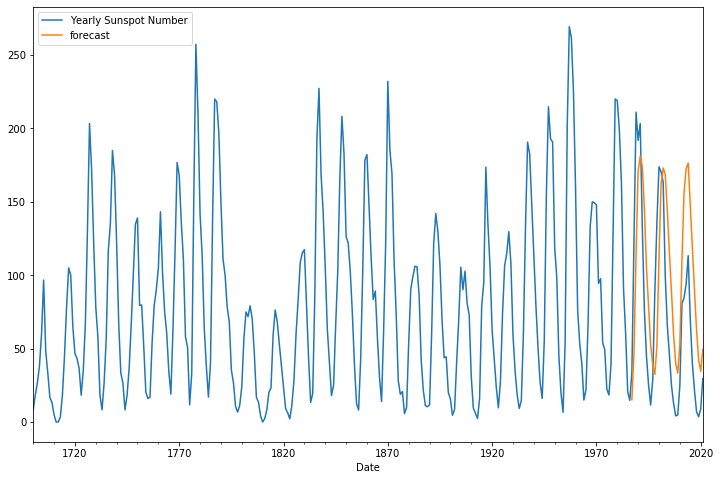

In [19]:
dfp[['Yearly Sunspot Number','forecast']].plot(figsize=(12,8))

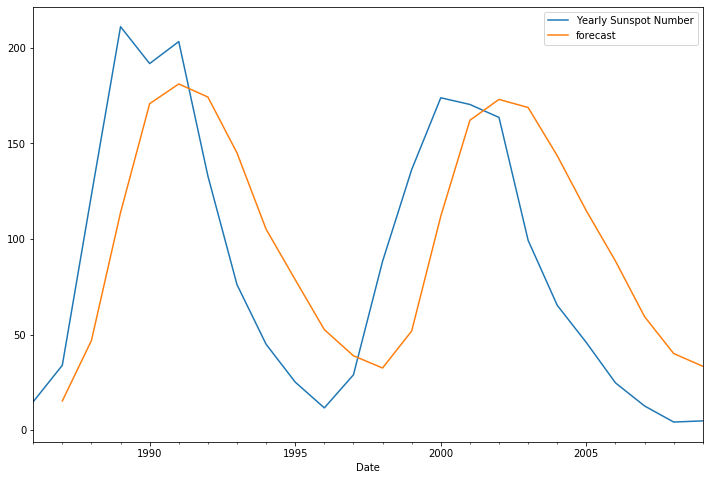

In [20]:
dfp['1986-06-01':'2010-01-01'][['Yearly Sunspot Number','forecast']].plot(figsize=(12,8))

In [42]:
import sklearn

In [43]:
sklearn.metrics.mean_squared_error(dfp['1987-06-01':'2010-01-01'][['forecast']],dfp['1987-06-01':'2010-01-01'][['Yearly Sunspot Number']] )

3025.7675165503315

### MAE

In [21]:
import sklearn.metrics
sklearn.metrics.mean_absolute_error(dfp['1987-06-01':'2010-01-01'][['Yearly Sunspot Number']], 
                                    dfp['1987-06-01':'2010-01-01'][['forecast']])

48.77925593306981

### RMSE

In [24]:
import numpy as np
np.sqrt(sklearn.metrics.mean_squared_error(dfp['1987-06-01':'2010-01-01'][['Yearly Sunspot Number']], 
                                    dfp['1987-06-01':'2010-01-01'][['forecast']]))

55.0069769806552